# Step Smarter, Not Harder: Queue-Aware Diffusion Sampling

**Course**: Modeling & Scaling GenAI Systems — Prof. Lydia Y. Chen (University of Neuchâtel)    
**Team**: Flaminia Trinca · Allizha Theiventhiram (JMCS - Swiss Joint Master in Computer Science)

## Project Overview

Diffusion models such as **DDPM** and **DDIM** are now standard tools for high-quality image generation.
However, despite their impressive visual fidelity, they pose a **fundamental systems challenge**:

> Diffusion sampling is *sequential*, *compute-intensive*, and *latency-sensitive*.

Each generated image requires running a large UNet for tens to hundreds of denoising steps.
When multiple requests arrive concurrently — as in a real deployed service — this quickly leads to **queue buildup**, **long waiting times**, and **unpredictable latency**, even on powerful GPUs.

This project studies diffusion **not as a static model**, but as a **served system under load**.

We ask:

* How does diffusion inference behave when requests arrive stochastically?
* How do latency and image quality trade off under different load levels?
* Can we **adapt computation at runtime** to control latency *without* collapsing quality?

## Core Idea

Our key observation is that **diffusion quality scales with the number of denoising steps**, while **latency scales almost linearly** with those same steps:

$$
S(n) \approx \alpha + \beta n,
$$

where $S(n)$ is the service time of a sampling request with $n$ steps.

This opens the door to a **queue-aware control mechanism**:

> When the system is lightly loaded, use expensive, high-quality sampling.
> When the queue grows, *shorten the sampling trajectory* to keep latency under control.

Concretely, we design and evaluate a **queue-aware early-exit policy** that dynamically chooses:

* the **sampling algorithm** (DDPM vs DDIM), and
* the **number of diffusion steps**,

based on the **current queue length**.

This idea is inspired by adaptive-depth systems (e.g. AppARATE, NSDI’24), but applied here to **diffusion sampling** in a queueing-theoretic setting.

## What This Notebook Does

This notebook is a **complete, end-to-end system study**, combining:

* empirical GPU profiling,
* diffusion quality evaluation,
* queueing theory,
* discrete-event simulation,
* controlled experiments with confidence intervals,
* and sensitivity analysis.

Specifically, we:

1. **Measure** DDPM and DDIM runtime as a function of step count.
2. **Fit** a service-time model $S(n) = \alpha + \beta n$ per dataset and sampler.
3. **Simulate** a single-GPU diffusion server as an **M/G/1 queue** with Poisson arrivals.
4. **Design** a queue-aware early-exit policy with tunable thresholds and step budgets.
5. **Evaluate** latency, waiting time, and image quality (CLIPScore, FID) under load.
6. **Compare** fixed baselines vs adaptive policies.
7. **Stress-test** the mechanism via ablations and robustness analysis.

All experiments are:

* fully reproducible,
* dataset-agnostic,
* and logged to disk for post-hoc analysis and plotting.

## Roadmap

The notebook is organized as follows:

1. **Environment & Reproducibility Setup**
   Seed control, device inspection, library versions, directory structure.

2. **Datasets and Data Loaders**
   Dataset choices (CIFAR-10, Flowers, CelebA-HQ), unified preprocessing, sanity checks.

3. **Diffusion Background and Unified Sampler**
   DDPM vs DDIM intuition, pipeline caching, and a unified `generate()` API.

4. **Quality Metrics — CLIPScore & FID**
   Motivation, implementation, and validation of quality measurements.

5. **Baseline Profiling — Measuring DDPM & DDIM Runtime**
   Empirical timing sweeps over step counts and datasets.

6. **Service-Time Model Fit**
   Fitting the linear model $S(n) = \alpha + \beta n$ used by the queue simulator.

7. **Queueing Model & Simulator**
   M/G/1 abstraction, Poisson arrivals, FIFO service, latency decomposition.

8. **Queue-Aware Early-Exit Mechanism**
   Three-level adaptive policy with thresholds and step budgets.

9. **Experiments: Latency–Quality Evaluation**
   Controlled simulations with confidence intervals and latency–quality trade-offs.

10. **Ablations & Sensitivity Analysis**
    Threshold placement, step budgets, sampler switching, robustness across datasets.

11. **Hypotheses & Analysis Goals**
    What we set out to test and how the results answer those questions.
---


## 1. Environment & Reproducibility Setup

**Setup**

- Uncomment the first cell if you run in Google Colab
- Change the variable `PROJECT_ROOT`to fir yout project root.

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Change directory into your project folder
PROJECT_ROOT = '/content/drive/My Drive/Uni/MSGAI/Project: MSGAI/3_final project'

In [7]:
%pip install -r '{PROJECT_ROOT}/requirements.txt' --quiet

**Imports**

In [8]:
import os
import sys
import time
import math
import random
import itertools
from dataclasses import dataclass
from typing import (Any, Callable, Dict, List, Optional, Tuple, Literal)
from collections import Counter
from matplotlib.colors import Normalize
import matplotlib.cm as cm

import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF

from datasets import load_dataset
import diffusers
from diffusers import DDPMPipeline, DDIMScheduler
import transformers
from transformers import CLIPModel, CLIPProcessor

from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision.models import inception_v3

from scipy.linalg import sqrtm

import matplotlib.pyplot as plt

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


**Device Info**

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))
    print("VRAM (GB):", round(torch.cuda.get_device_properties(0).total_memory / 1e9, 2))
else:
    print("Running on CPU (slower timing, OK for debugging).")

Device: cuda
GPU: Tesla T4
VRAM (GB): 15.83


**Library Versions**

In [12]:
print("\nVersion info:")
print("torch:", torch.__version__)
print("diffusers:", diffusers.__version__)
print("torchvision:", torchvision.__version__)
print("transformers:", transformers.__version__)
print("cuda:", torch.version.cuda, "available:", torch.cuda.is_available())


Version info:
torch: 2.9.0+cu126
diffusers: 0.36.0
torchvision: 0.24.0+cu126
transformers: 4.57.3
cuda: 12.6 available: True


**Reproducibility**

To ensure that all timing, profiling, queueing, and quality measurements in this notebook are **fully deterministic and repeatable**, we explicitly seed all relevant random number generators:

* Python’s `random`
* NumPy
* PyTorch (CPU and CUDA)

A single global seed (`SEED = 42`) is used throughout the entire notebook.
This prevents run-to-run variance, which is especially important when comparing queueing latency or fitting service-time models.

Similarly to this, we use the same image size (`IMG_SIZE = 32`) for all images. We do this in order for the notebook to fuly run on the Google Colab GPU. We tried to work with bigger image sizes, notably for the datasets "flowers" and "faces", but the GPU Memeory got clogged very fast, which prevented the whole notebook to run entirely.

In [13]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

IMG_SIZE = 32

**Project Directory Structure**

All logs, plots, and experiment outputs are stored under a configurable project root folder, defined via: `PROJECT_ROOT`

Inside this folder, the notebook automatically creates:

* `logs/` — profiling results, queueing outputs, quality summaries
* `plots/` — figures generated by experiments and ablations

These directories remain persistent across Colab sessions if stored in Google Drive.


In [14]:
os.makedirs(f"{PROJECT_ROOT}/logs", exist_ok=True)
os.makedirs(f"{PROJECT_ROOT}/plots", exist_ok=True)

---

## 2. Datasets and data loaders

### 2.1 Dataset choices

To evaluate queue-aware early exit, we need datasets that are

* small or moderately sized → allow many repeated profiling runs,
* visually diverse → ensure our conclusions do not depend on a single image domain,
* public and reproducible → so timing and quality measurements can be replicated.

We therefore use three datasets:

* **CIFAR-10**

  * 60k natural images, resolution (32 $\times$ 32), 10 classes.
  * Standard benchmark for small-resolution diffusion models.
  * Very cheap to sample from, ideal for many timing and queueing experiments.

* **Flowers-102** and **CelebA faces**

  * Colorful, highly textured flower images in 102 categories // Cropped face images from the `nielsr/CelebA-faces` dataset.
  * We rescale to (32 $\times$ 32) to preserve the same structure as for CIFAR-10 while staying lightweight.
  * Let us test whether the mechanism behaves similarly on more detailed natural scenes.

For each dataset we specify a small configuration object:

* `model_repo` → which pretrained DDPM checkpoint to use for sampling,
* `dataset_name` → how to load the real images (torchvision id or Hugging Face id),
* `image_dim` → target spatial resolution we resize to for that dataset.

All later experiments iterate over `DATASETS_INFO`, so adding a new dataset only requires extending this registry.

In [15]:
@dataclass
class DiffusionDataset:
    model_repo: str
    dataset_name: str
    image_dim: int

DATASETS_INFO: Dict[str, DiffusionDataset] = {
    "cifar10": DiffusionDataset(model_repo="google/ddpm-cifar10", dataset_name="cifar10", image_dim=IMG_SIZE),
    "flowers": DiffusionDataset(model_repo="anton-l/ddpm-ema-flowers-64", dataset_name="huggan/flowers-102-categories", image_dim=IMG_SIZE),
    "faces": DiffusionDataset(model_repo="google/ddpm-ema-celebahq-256", dataset_name="nielsr/CelebA-faces", image_dim=IMG_SIZE)

}

### 2.2 Unified transforms and dataset wrappers

To keep all downstream code (profiling, quality evaluation, queue simulation) dataset-agnostic, we normalize every dataset through the same small interface:

* resize and center-crop to the dataset’s configured `image_dim`,
* convert to a PyTorch tensor,
* normalize pixel values from ([0, 1]) to ([-1, 1]), as expected by our diffusion pipelines,
* return pairs `(image, label)` even if the label is unused (faces).

The following components implement this:

* `make_transforms(image_size)`   
  Common preprocessing pipeline applied to **all** datasets.

* `FlowersHFDataset`   
  Thin wrapper around the Hugging Face `"huggan/flowers-102-categories"` dataset.
  The original dataset only has a single `train` split, so we emulate train/val via
  `"train[:80%]"` and `"train[80%:]"`.

* `FacesHFDataset`   
  Wrapper around `"nielsr/CelebA-faces"`, with the same 80/20 train/val split logic as Flowers.
  Faces are treated as an unlabelled dataset (`label = 0`) because diffusion sampling is unconditional.

* `get_dataloaders(dataset_key, batch_size, num_workers)`   
  Factory that returns `(train_loader, val_loader)` for any key in `DATASETS_INFO`.
  Internally it chooses the correct underlying dataset class (torchvision CIFAR-10 vs HF Flowers/Faces) but exposes a uniform `DataLoader` API.

This design lets all later sections work with generic `train_loader` and `val_loader` objects, without hard-coding anything about the datasets themselves.


In [16]:
def make_transforms(image_size: int):
    """
    Alle images are
      - rezised/ center-cropped to image_size
      - turned into tensors
      - normalized from [0,1] to [-1,1]
    """
    return transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ])

In [17]:
class FlowersHFDataset(Dataset):
    """
    Wrapper around the Hugging Face 'huggan/flowers-102-categories' dataset.
    -> Flowers-102 only has.a train split, so we emulate train/ val via "train[:80]" and "train[80:]".

    Both CIFAR and Flowers eventually look like PyTorch Dataset objects that return (image, label)
    """
    def __init__(self, split_spec: str, image_size: int):
        super().__init__()
        self.ds = load_dataset("huggan/flowers-102-categories", split=split_spec)
        self.transform = make_transforms(image_size)

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        example = self.ds[idx]
        img = example["image"]
        label = example.get("label", 0)
        img = self.transform(img)
        return img, label

In [18]:
class FacesHFDataset(Dataset):
    """
    Wrapper around the Hugging Face 'nielsr/CelebA-faces' dataset.

    The dataset only has a 'train' split, so we emulate train/val via
    'train[:80%]' and 'train[80%:]', analogous to Flowers.
    """
    def __init__(self, split_spec: str, image_size: int):
        super().__init__()
        self.ds = load_dataset("nielsr/CelebA-faces", split=split_spec)
        self.transform = make_transforms(image_size)

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        example = self.ds[idx]
        img = example["image"]          # PIL.Image
        label = 0
        img = self.transform(img)
        return img, label

In [20]:
def get_dataloaders(dataset_key: str, batch_size: int = 64, num_workers: int = 2) -> Tuple[DataLoader, DataLoader]:
    """
    Create train/val dataloaders for the chosen dataset key.
    The rest of the notebook only depends on these loaders, not on dataset-specific details.
    """
    cfg = DATASETS_INFO[dataset_key]
    tfm = make_transforms(cfg.image_dim)

    if dataset_key == "cifar10":
        train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=tfm)
        val_ds = datasets.CIFAR10(root="./data", train=False, download=True, transform=tfm)

    elif dataset_key == "flowers":
        train_ds = FlowersHFDataset(split_spec="train[:80%]", image_size=cfg.image_dim)
        val_ds   = FlowersHFDataset(split_spec="train[80%:]", image_size=cfg.image_dim)

    elif dataset_key == "faces":
        train_ds = FacesHFDataset(split_spec="train[:80%]", image_size=cfg.image_dim)
        val_ds   = FacesHFDataset(split_spec="train[80%:]", image_size=cfg.image_dim)

    else:
        raise ValueError(f"Unknown dataset_key: {dataset_key}")

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=torch.cuda.is_available())
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=torch.cuda.is_available())

    return train_loader, val_loader

In [21]:
def display_grid(imgs, caption="Generated samples"):
    """Utility to display up to a 4×4 grid of images."""
    imgs = imgs.detach().cpu() # Move to CPU + detach before giving to matplotlib
    imgs = torch.clamp(imgs, 0, 1)

    n = min(len(imgs), 16)  # show at most 16 images
    plt.figure(figsize=(8, 8))
    for i in range(n):
        plt.subplot(4, 4, i + 1)
        plt.imshow(imgs[i].permute(1, 2, 0))
        plt.axis("off")
    plt.suptitle(caption)
    plt.show()

def display_and_save_grid(imgs, caption, save_path):
    imgs = imgs.detach().cpu()
    imgs = torch.clamp(imgs, 0, 1)

    n = min(len(imgs), 16)

    fig = plt.figure(figsize=(8, 8))
    for i in range(n):
        ax = fig.add_subplot(4, 4, i + 1)
        ax.imshow(imgs[i].permute(1, 2, 0))
        ax.axis("off")

    fig.suptitle(caption)
    fig.tight_layout()

    # --- save figure ---
    fig.savefig(save_path, dpi=120)
    plt.show()
    plt.close(fig)

### 2.3 Sanity check and visualization

Before using the datasets in profiling or queue simulations, we perform a simple sanity check for **each** dataset in `DATASETS_INFO`:

1. Build train and validation loaders with `get_dataloaders(dataset_key, batch_size=64)`.
2. Take one training batch and print:

   * the tensor shape ([B, 3, H, W]),
   * the value range (should be close to ([-1, 1]) after normalization).
3. Convert the images back to ([0, 1]) and display the first 16 samples in a (4 $\times$ 4) grid.
4. Save this grid as

   `PROJECT_ROOT/plots/dataset_sample_<dataset_key>.png`.

This confirms that:

* the dataset can be downloaded and loaded correctly,
* preprocessing and normalization behave as expected for the chosen resolution,
* the three datasets (CIFAR-10, Flowers, Faces) are correctly wired into the common loader interface.

Once these checks succeed, all subsequent sections (diffusion sampling, quality metrics, queue simulations, ablations) can be run without further dataset-specific adjustments.


=== Inspecting dataset: cifar10 ===
Batch shape: torch.Size([64, 3, 32, 32])
Range: [-1.00, 1.00]


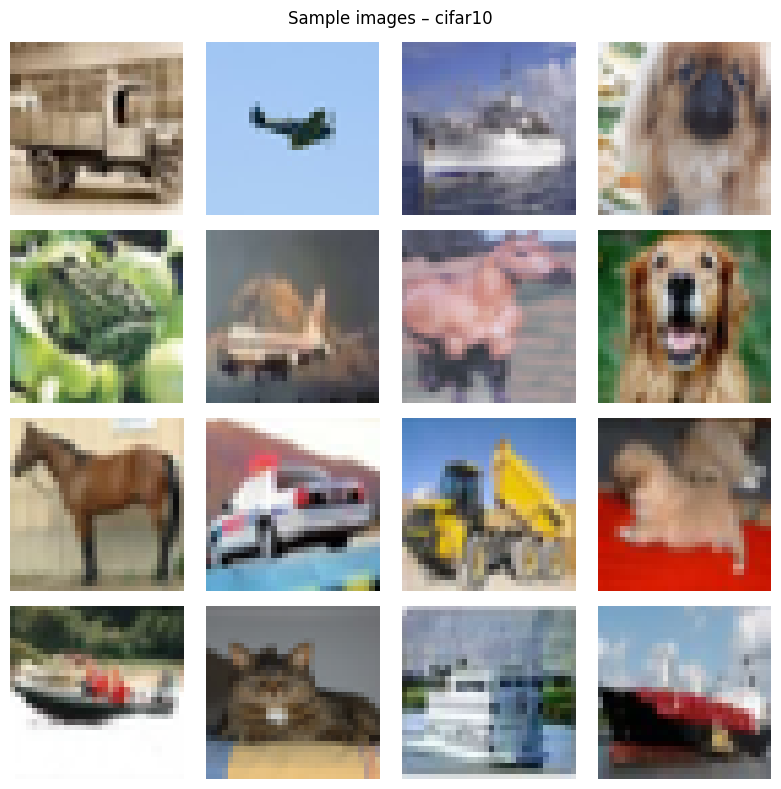

Saved sample grid → /content/drive/My Drive/Uni/MSGAI/Project: MSGAI/3_final project/plots/dataset_sample_cifar10.png

=== Inspecting dataset: flowers ===
Batch shape: torch.Size([64, 3, 32, 32])
Range: [-1.00, 1.00]


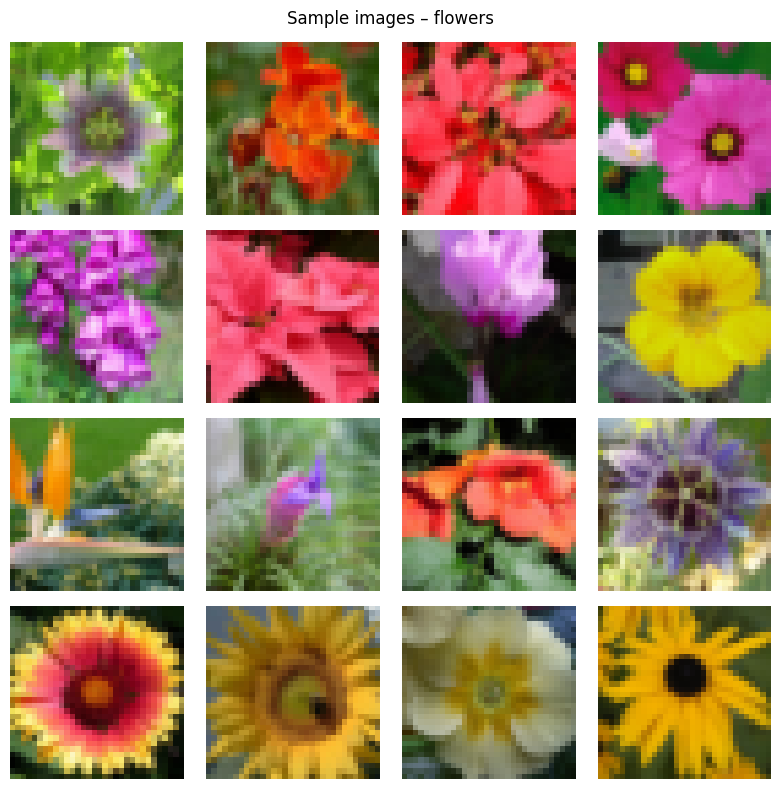

Saved sample grid → /content/drive/My Drive/Uni/MSGAI/Project: MSGAI/3_final project/plots/dataset_sample_flowers.png

=== Inspecting dataset: faces ===
Batch shape: torch.Size([64, 3, 32, 32])
Range: [-1.00, 1.00]


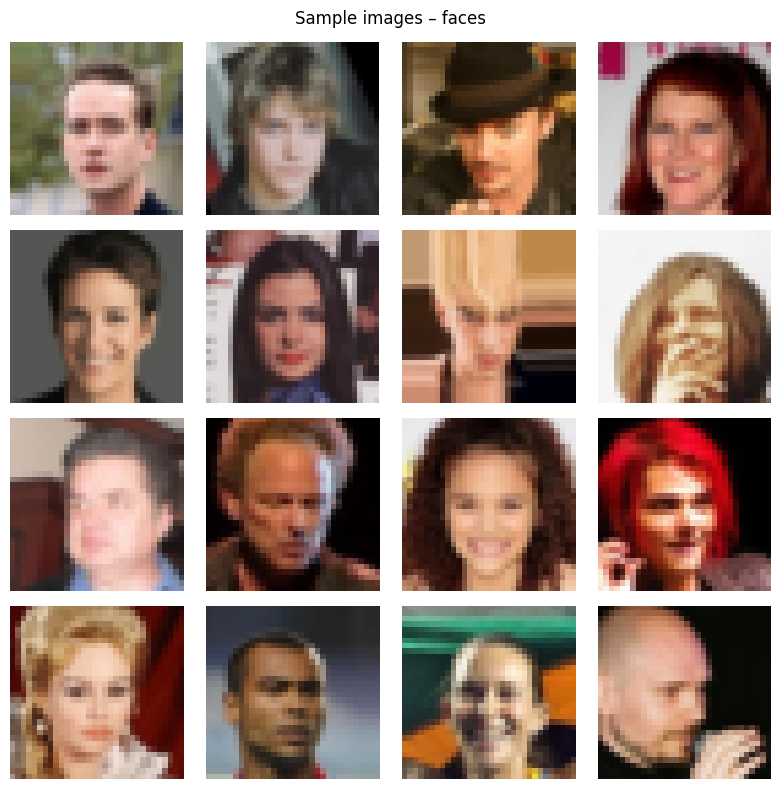

Saved sample grid → /content/drive/My Drive/Uni/MSGAI/Project: MSGAI/3_final project/plots/dataset_sample_faces.png


In [23]:
for dataset_key, cfg in DATASETS_INFO.items():
    print(f"\n=== Inspecting dataset: {dataset_key} ===")

    train_loader, val_loader = get_dataloaders(dataset_key, batch_size=64)
    imgs, labels = next(iter(train_loader))
    print("Batch shape:", imgs.shape)
    print("Range: [%.2f, %.2f]" % (imgs.min().item(), imgs.max().item()))

    imgs_vis = imgs * 0.5 + 0.5

    save_path = f"{PROJECT_ROOT}/plots/dataset_sample_{dataset_key}.png"
    caption   = f"Sample images – {dataset_key}"

    display_and_save_grid(imgs_vis[:16], caption, save_path)

    print(f"Saved sample grid → {save_path}")

### 2.4 Sanity-check interpretation

The sanity check confirms that all datasets are correctly integrated into a **uniform data loading and preprocessing pipeline**:

* For **CIFAR-10**, **Flowers-102**, and **CelebA-Faces**, each training batch has shape
  ([64, 3, 32, 32]), confirming consistent spatial resolution and channel layout.
* Pixel values lie in the range ([-1, 1]), matching the input normalization expected by the diffusion pipelines.
* Visual inspection of the saved image grids shows:

  * CIFAR-10 contains small, low-detail natural images,
  * Flowers exhibit richer textures and color variation,
  * Faces contain structured, high-frequency facial features despite aggressive downscaling.

These checks validate that:

1. Dataset downloads and loaders function correctly,
2. Preprocessing is applied consistently across datasets,
3. All datasets can be treated interchangeably by downstream components.

As a result, **any differences in latency, queueing behavior, or quality observed in later sections can be attributed to the diffusion models and sampling policies rather than data-loading artifacts**.

---

## 3. Diffusion Background and Unified Sampler

### 3.1 Diffusion model intuition

Diffusion models generate images by starting from **pure Gaussian noise** and progressively denoising it.
Each denoising step involves **one forward pass through a UNet**, making sampling cost **linear in the number of steps**.

This is exactly why diffusion models create queueing problems: large chains → long service times → congestion.

#### **→ DDPM — Denoising Diffusion Probabilistic Models**

DDPM follows a **stochastic** reverse diffusion process:

* At each step, the model predicts noise to remove
* A small amount of noise is re-added (variance schedule)
* Often uses **hundreds–thousands** of steps

**Pros:** High-quality, stable sampling

**Cons:** Slow — large number of sequential steps


#### **→ DDIM — Denoising Diffusion Implicit Models**

DDIM uses the **same UNet**, but a deterministic update rule:

* No stochastic noise re-injection
* Can skip steps (e.g., 20–50 steps still workable)

**Pros:** Much faster; Predictable, deterministic sampling

**Cons:** At extremely low step counts, quality drops faster than DDPM

#### **Why this matters for queueing**

Each reverse step → **one UNet forward pass** → dominant contributor to latency.

Therefore:

$$
S(n) \propto n,
$$

where $S(n)$ is the service time for a job using $n$ steps.

> In our experiments, one “job” corresponds to one sampling request that generates a *batch* of $b=\#imgs$ (e.g., 4 or 8), so the measured service time $S(n)$ refers to a batch request rather than a single image.

Long step chains increase:

* Service time
* Queue length
* Total end-to-end latency

This motivates queue-dependent early exit:

> When the queue is empty → use full DDPM.
> When congested → reduce steps or switch to DDIM.

### 3.2 Avoiding repeated model loading (pipeline cache)

We keep a global cache so the notebook does **not re-load HF pipelines for every sampling call**.

In [24]:
AlgoType = Literal["ddpm", "ddim"]

# Global cache to avoid re-loading the same pipelines over and over
_PIPELINE_CACHE: Dict[Tuple[str, AlgoType], DDPMPipeline] = {}

# Global profiling log, to be turned into a DataFrame later for S(n) = α + β·n
PROFILE_LOGS: List[Dict[str, Any]] = []

### 3.3 Loading DDPM / DDIM pipelines per dataset

This function:

* Loads the correct pretrained DDPM from HuggingFace
* Swaps the scheduler for DDIM when needed
* Moves the model to GPU
* Stores it in the cache

In [26]:
def build_pipeline_from_dataset(dataset_key: str, algo: AlgoType, device: torch.device | None = None) -> DDPMPipeline:
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    cfg = DATASETS_INFO[dataset_key]
    cache_key = (cfg.model_repo, algo)

    if cache_key not in _PIPELINE_CACHE:
        # Load on CPU by default (important!)
        pipe = DDPMPipeline.from_pretrained(cfg.model_repo, torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,).to("cpu")

        if algo == "ddim":
            pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

        pipe.set_progress_bar_config(disable=True)
        _PIPELINE_CACHE[cache_key] = pipe

    return _PIPELINE_CACHE[cache_key].to(device)

### 3.4 Unified sampling API `generate()`

This is the **heart of the service-time model**. It:

1. Loads the correct pipeline
2. Seeds sampling for reproducibility
3. Runs diffusion for the number of `steps` iterations
4. Measures **total time** and **per-step time**
5. Converts images to PyTorch format
6. Optionally logs results to `PROFILE_LOGS` (important for experiments later)


> **Note:** `generate()` measures latency for generating `n_imgs` images in a single call. Throughout the notebook, we treat this call as one inference *job* (i.e., batch-level service time).

In [28]:
def generate(algo: AlgoType, steps: int, n_imgs: int = 8, dataset_key: str = "cifar10", seed: int | None = None, device: torch.device | None = None, log_run: bool = True) -> Tuple[torch.Tensor, Dict[str, Any]]:
    if device is None: device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    algo = algo.lower()
    assert algo in {"ddpm", "ddim"}, f"Unknown algo: {algo}"

    # Build / fetch pipeline
    pipe = build_pipeline_from_dataset(dataset_key, algo, device=device)

    # Seed for reproducibility
    if seed is None: seed = int(time.time()) % (2**31)
    generator = torch.Generator(device=device).manual_seed(seed)

    # Time the full sampling run
    if device.type == "cuda": torch.cuda.synchronize()
    t0 = time.time()

    result = pipe(batch_size=n_imgs, num_inference_steps=steps, output_type="np", generator=generator)

    if device.type == "cuda": torch.cuda.synchronize()
    t1 = time.time()

    elapsed_s = t1 - t0
    per_step_ms = (elapsed_s / max(steps, 1)) * 1000.0

    # Convert images: (N, H, W, C) -> (N, C, H, W) in [0, 1]
    imgs_np = np.asarray(result.images, dtype=np.float32)  # assumed in [0,1]
    imgs = torch.from_numpy(imgs_np).permute(0, 3, 1, 2)

    # Handle grayscale just in case (MNIST-style)
    if imgs.shape[1] == 1: imgs = imgs.repeat(1, 3, 1, 1)

    imgs = imgs.to(device)
    stats = {"algo": algo.upper(), "steps": int(steps), "n_imgs": int(n_imgs), "dataset": dataset_key, "seed": int(seed), "total_s": float(elapsed_s), "per_step_ms": float(per_step_ms)}

    if log_run: PROFILE_LOGS.append(stats)

    return imgs, stats

The returned `stats` dictionary includes:

* algo (DDPM/DDIM)
* number of steps
* dataset
* total runtime
* runtime per step

This function is used for:

* Profiling (Section 5)
* Quality sweeps (Section 9)
* The entire queue simulator (Sections 7–10)

### 3.5 Converting profile logs into a DataFrame

Later sections expect a DataFrame with:

* algo
* steps
* dataset
* total runtime
* per-step runtime

In [29]:
def profile_to_df() -> pd.DataFrame:
    """
    Turn PROFILE_LOGS into a pandas DataFrame for fitting S(n) = α + β·n later.
    """
    if not PROFILE_LOGS:
        return pd.DataFrame(columns=["algo", "steps", "n_imgs", "dataset", "seed", "total_s", "per_step_ms"])
    return pd.DataFrame(PROFILE_LOGS)

### 3.6 Sanity Check: Sample images from DDPM / DDIM on all datasets

This verifies:

* The pipelines load correctly
* Both algorithms run on every dataset
* Images look reasonable
* Timing does not crash


=== DDPM ===

--- Dataset: cifar10 ---
{'algo': 'DDPM', 'steps': 50, 'n_imgs': 4, 'dataset': 'cifar10', 'seed': 42, 'total_s': 1.0178840160369873, 'per_step_ms': 20.357680320739746}


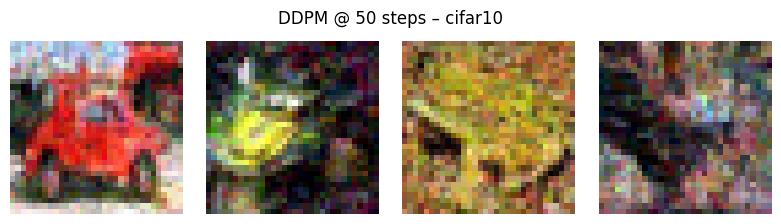

Saved sanity-check grid → /content/drive/My Drive/Uni/MSGAI/Project: MSGAI/3_final project/plots/sanity_ddpm_cifar10.png

--- Dataset: flowers ---
{'algo': 'DDPM', 'steps': 50, 'n_imgs': 4, 'dataset': 'flowers', 'seed': 42, 'total_s': 1.428267002105713, 'per_step_ms': 28.565340042114258}


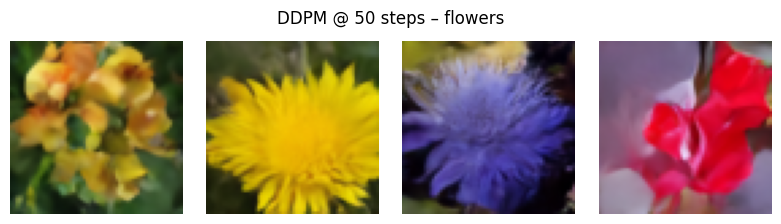

Saved sanity-check grid → /content/drive/My Drive/Uni/MSGAI/Project: MSGAI/3_final project/plots/sanity_ddpm_flowers.png

--- Dataset: faces ---
{'algo': 'DDPM', 'steps': 50, 'n_imgs': 4, 'dataset': 'faces', 'seed': 42, 'total_s': 9.568966150283813, 'per_step_ms': 191.37932300567627}


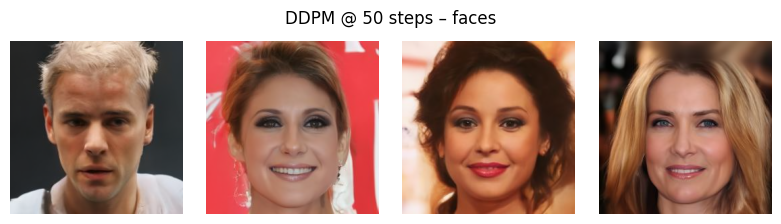

Saved sanity-check grid → /content/drive/My Drive/Uni/MSGAI/Project: MSGAI/3_final project/plots/sanity_ddpm_faces.png

=== DDIM ===

--- Dataset: cifar10 ---
{'algo': 'DDIM', 'steps': 50, 'n_imgs': 4, 'dataset': 'cifar10', 'seed': 42, 'total_s': 0.9854960441589355, 'per_step_ms': 19.70992088317871}


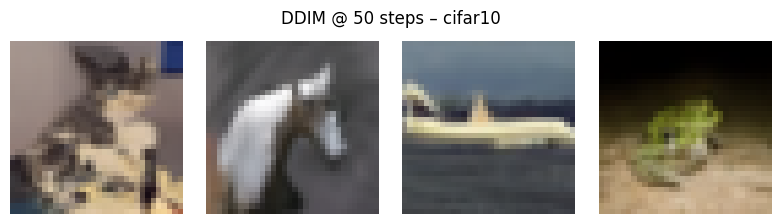

Saved sanity-check grid → /content/drive/My Drive/Uni/MSGAI/Project: MSGAI/3_final project/plots/sanity_ddim_cifar10.png

--- Dataset: flowers ---
{'algo': 'DDIM', 'steps': 50, 'n_imgs': 4, 'dataset': 'flowers', 'seed': 42, 'total_s': 1.4076206684112549, 'per_step_ms': 28.152413368225098}


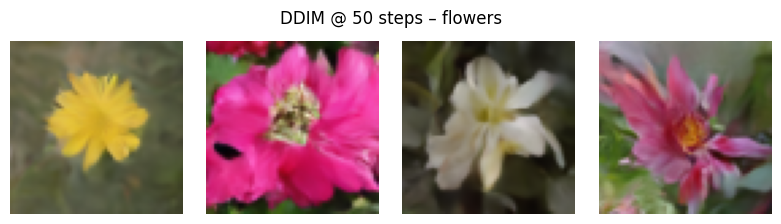

Saved sanity-check grid → /content/drive/My Drive/Uni/MSGAI/Project: MSGAI/3_final project/plots/sanity_ddim_flowers.png

--- Dataset: faces ---
{'algo': 'DDIM', 'steps': 50, 'n_imgs': 4, 'dataset': 'faces', 'seed': 42, 'total_s': 9.630281686782837, 'per_step_ms': 192.60563373565674}


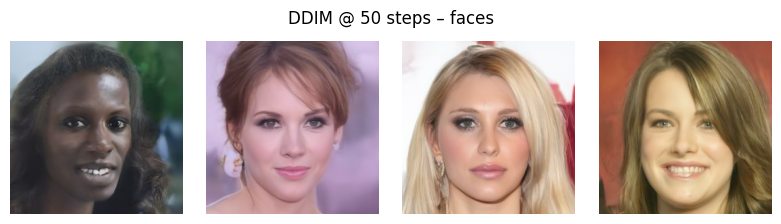

Saved sanity-check grid → /content/drive/My Drive/Uni/MSGAI/Project: MSGAI/3_final project/plots/sanity_ddim_faces.png


In [31]:
for algo in ("ddpm", "ddim"):

    print(f"\n=== {algo.upper()} ===")

    for dataset_key in DATASETS_INFO.keys():
        print(f"\n--- Dataset: {dataset_key} ---")

        # Generate 4 images at 50 steps
        imgs, stats = generate(algo=algo, steps=50, n_imgs=4, dataset_key=dataset_key, seed=SEED, log_run=False)
        print(stats)

        # Convert to [0,1] for visualization
        imgs_vis = torch.clamp(imgs.detach().cpu(), 0, 1)

        # Build plot filename
        save_path = f"{PROJECT_ROOT}/plots/sanity_{algo}_{dataset_key}.png"
        caption   = f"{stats['algo']} @ {stats['steps']} steps – {dataset_key}"

        # Display & save
        display_and_save_grid(imgs_vis, caption, save_path)

        print(f"Saved sanity-check grid → {save_path}")

### 3.7 Sanity-Check Interpretation (DDPM / DDIM Sampling)

This sanity check confirms that:

* all diffusion pipelines (DDPM and DDIM) load correctly for **all datasets**,
* the unified `generate()` API works consistently,
* timing statistics can be collected reliably.

#### Notes on warnings

* The message about missing `diffusion_pytorch_model.safetensors` indicates that some checkpoints are stored in `.bin` format. Diffusers falls back automatically; sampling correctness is unaffected.
* The float16/CPU warning appears because pipelines are initialized with GPU-oriented defaults. Since all sampling is executed on CUDA, this warning can be ignored.

#### What the timing results show

At **50 denoising steps** with batch size `n_imgs = 4`, we observe:

| dataset | algo | total_s | per_step_ms |
| ------- | ---- | ------- | ----------- |
| cifar10 | DDPM | 1.018   | 20.36       |
| cifar10 | DDIM | 0.986   | 19.71       |
| flowers | DDPM | 1.428   | 28.57       |
| flowers | DDIM | 1.408   | 28.15       |
| faces   | DDPM | 9.569   | 191.38      |
| faces   | DDIM | 9.630   | 192.61      |

Key observations:

* **DDPM vs DDIM:**
  For the *same number of steps*, DDPM and DDIM have **very similar per-step cost**. DDIM is not inherently faster per step; its advantage comes from achieving acceptable quality with **fewer steps**, not cheaper steps.

* **Dataset/model effect dominates runtime:**
  Even though all images are resized, the **underlying diffusion model architecture** differs substantially:

  * CIFAR-10 models are lightweight → fast per-step times.
  * Flowers models are moderately heavier.
  * Faces (CelebA-HQ) models are much larger → ~10× higher per-step cost.

* **Implication for queueing:**
  At the same arrival rate and step count, larger models reach high utilization much earlier. This strongly motivates **queue-aware early-exit policies** that reduce step counts or switch to DDIM under load.

Overall, this sanity check validates a core assumption used throughout the notebook:
**total sampling latency scales approximately linearly with the number of denoising steps, but the per-step cost is dataset/model dependent.**


---

## 4. Quality metrics — CLIPScore & FID


### 4.1 Motivation

To evaluate the effect of early-exit decisions, we must quantify **how image quality changes** when we modify the number of diffusion steps or switch between DDPM and DDIM.
Our queueing policy reduces computation under load, so a fair comparison requires measuring **quality and latency together**.

In this project, every experiment changes the **service time** by changing

$$
(\text{algo}, \text{steps})
$$

and therefore changes the **distribution of generated images**. Quality metrics allow us to:

* Compare DDPM vs DDIM at equal step counts.
* Measure the degradation introduced by shorter sampling chains.
* Evaluate our adaptive policy vs fixed baselines.
* Visualize the **latency–quality trade-off**, which is the core contribution of the project.

Because we are designing a *serving* system, we need metrics that are:

* Fast enough to compute repeatedly inside a notebook.
* Sensitive to major quality differences.
* Stable enough to compare across different arrival rates $\lambda$ and datasets.

We therefore use **two complementary metrics**: CLIPScore and FID.

### 4.2 CLIPScore

CLIPScore uses a pretrained **vision–language model** (CLIP) to measure how well an image aligns with a text description.
Although CLIPScore is designed for text-to-image systems, it also provides a proxy for **visual coherence and realism** in unconditional diffusion models when paired with a generic caption such as

> "a photo"

Strengths:

* Extremely fast (suitable for per-experiment evaluation).
* Works with relatively small sample sizes.
* Sensitive to obvious visual artifacts.
* Easy to integrate into the notebook workflow.

In this notebook, we treat CLIPScore as a **primary quality signal** for comparing policies at different loads.

### 4.3 FID — Frechet Inception Distance

FID compares the **distribution** of real images and generated images in the feature space of an Inception network.

Properties:

* Lower FID means the model’s sample distribution is closer to the real one.
* Widely used as a **gold standard** for generative model comparison.
* Requires computing means and covariances of deep feature activations.

Drawbacks:

* Computationally expensive.
* Needs hundreds to thousands of images to be numerically stable.
* Not suitable for being called inside tight inner loops (e.g., every queue simulation).

In our project, FID is computed **once per configuration** on reasonably large batches, and then reused when interpreting the queueing policies.

### 4.4 Implementation details

All metric code is written to be compatible with **all datasets** configured in `DATASETS_INFO`:

* Diffusion outputs are in ([0, 1]), while dataset images arrive normalized to ([-1, 1]).
  Both metric functions internally convert their inputs to the required range.
* Images are always represented as tensors of shape ([N, 3, H, W]).
* CLIPScore uses the Hugging Face `CLIPModel` and `CLIPProcessor`.
* FID uses `torchmetrics.image.FrechetInceptionDistance`, which handles Inception features and the Frechet distance computation.

We provide the following utilities:

* `compute_clipscores(images, texts=None)`   
  Returns per-image CLIPScores and their mean for a batch of images.

* `initialize_fid_metric()`, `update_fid_metric()`, `compute_final_fid()`   
  A streaming interface for FID, suitable for accumulating real and fake features over multiple batches and computing a final scalar FID value.

**CLIP Score**

In [32]:
_CLIP_MODEL = None
_CLIP_PROCESSOR = None

def _get_clip(device: torch.device):
    """Lazy-load CLIP model + processor once, reuse for all calls."""
    global _CLIP_MODEL, _CLIP_PROCESSOR
    if _CLIP_MODEL is None or _CLIP_PROCESSOR is None:
        name = "openai/clip-vit-base-patch32"
        _CLIP_MODEL = CLIPModel.from_pretrained(name).to(device)
        _CLIP_MODEL.eval()
        _CLIP_PROCESSOR = CLIPProcessor.from_pretrained(name)
    return _CLIP_MODEL, _CLIP_PROCESSOR


def _to_pil_list(images: torch.Tensor):
    """Convert [-1,1] or [0,1] tensors into a list of PIL images in [0,1]."""
    if images.min() < 0:
        imgs01 = (images * 0.5 + 0.5).clamp(0, 1)
    else:
        imgs01 = images.clamp(0, 1)

    imgs01 = imgs01.detach().cpu()
    return [TF.to_pil_image(img) for img in imgs01]

In [33]:
def compute_clipscores(images: torch.Tensor, texts: Optional[List[str]] = None, device: Optional[torch.device] = None, batch_size: int = 32):
    """Compute CLIPScore for a batch of images."""
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model, processor = _get_clip(device)
    N = images.shape[0]

    if texts is None:
        texts = ["a photo"] * N

    pil_imgs = _to_pil_list(images)

    scores_all = []
    with torch.no_grad():
        for start in range(0, N, batch_size):
            end = min(start + batch_size, N)
            batch_imgs = pil_imgs[start:end]
            batch_txts = texts[start:end]

            inputs = processor(text=batch_txts, images=batch_imgs, return_tensors="pt", padding=True).to(device)

            outputs = model(**inputs)
            img_emb = outputs.image_embeds
            txt_emb = outputs.text_embeds

            img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)
            txt_emb = txt_emb / txt_emb.norm(dim=-1, keepdim=True)
            scores = (img_emb * txt_emb).sum(dim=-1)

            scores_all.append(scores.cpu())

    scores = torch.cat(scores_all).numpy()
    return scores, float(scores.mean())

**FID**

In [34]:
def initialize_fid_metric(device):
    return FrechetInceptionDistance(feature=2048, normalize=True).to(device)

def update_fid_metric(fid_metric, real_imgs, fake_imgs, device, batch_size: int = 32):
    # real_imgs: CPU [-1,1], fake_imgs: CPU [0,1]
    n = min(len(real_imgs), len(fake_imgs))
    for i in range(0, n, batch_size):
        r = real_imgs[i:i+batch_size]
        f = fake_imgs[i:i+batch_size]

        real_uint8 = ((r * 0.5 + 0.5) * 255).to(torch.uint8).to(device, non_blocking=True)
        fake_uint8 = (f * 255).to(torch.uint8).to(device, non_blocking=True)

        fid_metric.update(real_uint8, real=True)
        fid_metric.update(fake_uint8, real=False)


def compute_final_fid(fid_metric):
    return fid_metric.compute().item()

### 4.5 Sanity check

Before using these metrics in larger experiments, we run a small **sanity check**:

* Take a real batch from the training loader of the active dataset (images in ([-1, 1])).
* For each sampler `algo ∈ {ddpm, ddim}` and for each dataset in `DATASETS_INFO`:

  * Generate a small fake batch using `generate(algo=..., steps=50, n_imgs=8, ...)`.
  * Compute CLIPScore for the fake batch.
  * Compute FID between the real batch and the fake batch.

This check verifies that:

* The metric functions run without errors on GPU.
* The input ranges and shapes are handled correctly.
* The CLIP/FID values are in a reasonable numeric range (not NaN or exploding).

In [36]:
for dataset_key in DATASETS_INFO:
  print(f"\n=== {dataset_key} ===")
  # Real batch from dataset (in [-1,1])
  train_loader, _ = get_dataloaders(dataset_key, batch_size=64)
  real_batch, _ = next(iter(train_loader))
  real_batch = real_batch.to(device)

  for algo in ("ddpm", "ddim"):
    if algo == "ddpm":
      print("\n===== DDPM =====")
    else:
      print("\n===== DDIM =====")

    # Fake batch using unified sampler
    fake_batch, stats = generate(algo=algo, steps=50, n_imgs=8, dataset_key=dataset_key, seed=SEED, device=device, log_run=False)
    print("Generation stats:", stats)

    # CLIPScore Example
    clip_scores, clip_mean = compute_clipscores(fake_batch, device=device, batch_size=8)
    print(f"CLIPScore — mean: {clip_mean:.3f}")

    # FID Example (small subset)
    fid_metric = initialize_fid_metric(device)
    update_fid_metric(fid_metric, real_batch, fake_batch.detach().cpu(), device)
    fid_val = compute_final_fid(fid_metric)
    print(f"FID: {fid_val:.2f}")


=== cifar10 ===

===== DDPM =====
Generation stats: {'algo': 'DDPM', 'steps': 50, 'n_imgs': 8, 'dataset': 'cifar10', 'seed': 42, 'total_s': 1.0402085781097412, 'per_step_ms': 20.804171562194824}
CLIPScore — mean: 0.224
FID: 402.64

===== DDIM =====
Generation stats: {'algo': 'DDIM', 'steps': 50, 'n_imgs': 8, 'dataset': 'cifar10', 'seed': 42, 'total_s': 1.3321022987365723, 'per_step_ms': 26.642045974731445}
CLIPScore — mean: 0.222
FID: 342.34

=== flowers ===

===== DDPM =====
Generation stats: {'algo': 'DDPM', 'steps': 50, 'n_imgs': 8, 'dataset': 'flowers', 'seed': 42, 'total_s': 1.8040106296539307, 'per_step_ms': 36.08021259307861}
CLIPScore — mean: 0.236
FID: 275.05

===== DDIM =====
Generation stats: {'algo': 'DDIM', 'steps': 50, 'n_imgs': 8, 'dataset': 'flowers', 'seed': 42, 'total_s': 2.0329456329345703, 'per_step_ms': 40.658912658691406}
CLIPScore — mean: 0.229
FID: 277.13

=== faces ===

===== DDPM =====
Generation stats: {'algo': 'DDPM', 'steps': 50, 'n_imgs': 8, 'dataset': 'f

### 4.6 Sanity-check interpretation (CLIPScore & FID)

This sanity check verifies that **CLIPScore and FID are computed correctly** for all datasets and both sampling algorithms using the unified pipeline. All metrics return finite values with no shape, range, or numerical issues.

**Sanity-check results at 50 steps (batch size = 8)**

| dataset | sampler | CLIPScore ↑ | FID ↓  | total time (s) |
| ------- | ------- | ----------- | ------ | -------------- |
| cifar10 | DDPM    | 0.224       | 402.64 | 1.04           |
| cifar10 | DDIM    | 0.222       | 342.34 | 1.33           |
| flowers | DDPM    | 0.236       | 275.05 | 1.80           |
| flowers | DDIM    | 0.229       | 277.13 | 2.03           |
| faces   | DDPM    | 0.234       | 364.78 | 19.04          |
| faces   | DDIM    | 0.228       | 369.28 | 19.19          |


**What these results show**

**CLIPScore.** Scores are tightly clustered (≈0.22–0.24) across datasets and samplers. This is expected because:

* we use a generic prompt (“a photo”),
* the batch size is very small (8 images),
* differences at fixed step count are subtle.

In this project, CLIPScore is used primarily as a **relative indicator** of quality trends when step counts are reduced or policies change.

**FID.** FID values are very large and noisy (≈275–400). This is expected and not a concern:

* FID is statistically unstable with such small sample sizes,
* these runs are only a *sanity check*, not final quality evaluation.

Later sections compute FID using hundreds of images to obtain meaningful comparisons.

**DDPM vs DDIM: why results are similar here**

At a **fixed number of steps (50)**:

* DDPM and DDIM run the **same UNet architecture**,
* each step has similar computational cost,
* therefore, total runtime and per-step latency are comparable.

DDIM is **not inherently faster per step**. Its advantage comes from the ability to:

* run with **many fewer steps** (e.g. 20 instead of 100),
* while maintaining acceptable quality.

This is exactly what our queue-aware policy will exploit later:
**DDIM enables graceful quality degradation under load by shortening the sampling chain**, not by speeding up individual steps.

---

## 5. Baseline Profiling — Measuring DDPM & DDIM Runtime

### 5.1 Motivation

Before we can embed diffusion sampling inside an M/G/1 queue, we must understand **how long a single inference call takes** as a function of:

* the **sampling algorithm** (DDPM vs DDIM),
* the **number of denoising steps** $n$,
* and the **dataset resolution**.

This section produces the empirical timing data required to fit the **service-time model**

$$
S(n) \approx \alpha + \beta n,
$$

where:

* $\alpha$ = fixed overhead per request (latents allocation, pipeline warmup, kernel setup),
* $\beta$ = average time **per denoising step**.

This linear model is the backbone of the queueing simulator developed later.

### 5.2 What We Profile

For each dataset:

$$
\text{dataset} \in \{\text{cifar10}, \text{flowers}, \text{faces}\},
$$

and for each sampling algorithm:

$$
\text{algo} \in \{\text{DDPM}, \text{DDIM}\},
$$

we run multiple inference calls at different step counts:

$$
n \in \{5, 10, 25, 50, 100, 250\}.
$$

Each profiling call:

1. Generates a **small batch** of images (default: 4) with

   ```python
   generate(algo=..., steps=n, n_imgs=4)
   ```
2. Measures:

   * total runtime $S(n)$ for the batch,
   * derived **per-step latency** $S(n)/n$,
3. Logs results into the global `PROFILE_LOGS`.

At the end of the sweep, results are saved to:

```
{PROJECT_ROOT}/logs/baseline_profiling_<dataset>.csv
```

These CSVs become the input to **Section 6**, where we estimate
$\alpha$ and $\beta$ for each dataset–algorithm pair.

### 5.3 Why This Step Is Crucial

This profiling step defines the **service-time distribution** used in our M/G/1 queue model.
Without accurate timing measurements, the simulator in Section 7 would produce meaningless waiting times.

Specifically:

* The slope $\beta$ determines *how quickly service time grows* with the number of steps.
* The intercept $\alpha$ captures fixed overhead unrelated to step count.
* DDPM and DDIM differ in both parameters, which is essential for early-exit decisions.

Every latency plot, policy comparison, and ablation study downstream **depends directly** on this profiling.

### 5.4 Running the Profiling Sweep

In [37]:
os.makedirs(f"{PROJECT_ROOT}/logs", exist_ok=True)

def run_baseline_profiling(dataset_key: str, algos=("ddpm", "ddim"), step_counts=(5, 10, 25, 50, 100, 250), batch_size=4, seed=42, device=None, clear_logs=True, csv_prefix="baseline_profiling"):
    """
    Run a full profiling sweep for (algo × steps) combinations.
    Produces the CSV used for service-time fitting.
    """
    global PROFILE_LOGS

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if clear_logs:
        PROFILE_LOGS.clear()

    print(f"Running baseline profiling on dataset='{dataset_key}'")
    print(f"Algorithms: {algos}, steps: {list(step_counts)}, batch_size={batch_size}\n")

    for algo in algos:
        for k in step_counts:
            imgs, stats = generate(algo=algo, steps=k, n_imgs=batch_size, dataset_key=dataset_key, seed=seed, device=device, log_run=True)
            print(f"[{stats['algo']}] steps={stats['steps']:3d} | "
                  f"total={stats['total_s']:.3f}s | per_step={stats['per_step_ms']:.2f} ms")

    # Convert results to DataFrame
    df_profile = profile_to_df()

    # Build CSV path using PROJECT_ROOT
    csv_path = f"{PROJECT_ROOT}/logs/{csv_prefix}_{dataset_key}.csv"

    df_profile.to_csv(csv_path, index=False)
    print(f"\nSaved profiling results → {csv_path}")

    return df_profile, csv_path

### 5.5 Plotting Total Runtime vs. Number of Steps

In [38]:
def plot_baseline_profiling(df_profile, dataset_key: str, batch_size: int):
    """
    Plot total runtime vs. number of steps for DDPM and DDIM.
    """
    plt.figure(figsize=(6, 4))

    for algo in df_profile["algo"].unique():
        sub = df_profile[df_profile["algo"] == algo].sort_values("steps")
        plt.plot(sub["steps"], sub["total_s"], marker="o", label=algo)

    plt.xlabel("Number of denoising steps")
    plt.ylabel(f"Total runtime (s) for batch of {batch_size}")
    plt.title(f"Baseline profiling on {dataset_key}")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

### 5.6 Running Profiling for All Datasets

In [41]:
RUN_PROFILING = True # set to False after first successful run

for dataset_key in DATASETS_INFO.keys():
  print(f"\n=== {dataset_key} ===\n")
  if RUN_PROFILING:
      df_profile, csv_path = run_baseline_profiling(dataset_key=dataset_key, algos=("ddpm", "ddim"), step_counts=(5, 10, 25, 50, 100, 250), batch_size=4, seed=SEED, device=device, clear_logs=True, csv_prefix="baseline_profiling")
      print("\nProfiling finished. First rows:")
      display(df_profile.head())
  else:
      print("Skipping profiling run (RUN_PROFILING = False)")


=== cifar10 ===

Running baseline profiling on dataset='cifar10'
Algorithms: ('ddpm', 'ddim'), steps: [5, 10, 25, 50, 100, 250], batch_size=4

[DDPM] steps=  5 | total=0.101s | per_step=20.23 ms
[DDPM] steps= 10 | total=0.198s | per_step=19.75 ms
[DDPM] steps= 25 | total=0.495s | per_step=19.78 ms
[DDPM] steps= 50 | total=0.964s | per_step=19.27 ms
[DDPM] steps=100 | total=1.951s | per_step=19.51 ms
[DDPM] steps=250 | total=5.654s | per_step=22.62 ms
[DDIM] steps=  5 | total=0.152s | per_step=30.45 ms
[DDIM] steps= 10 | total=0.247s | per_step=24.73 ms
[DDIM] steps= 25 | total=0.497s | per_step=19.90 ms
[DDIM] steps= 50 | total=0.961s | per_step=19.21 ms
[DDIM] steps=100 | total=1.903s | per_step=19.03 ms
[DDIM] steps=250 | total=4.703s | per_step=18.81 ms

Saved profiling results → /content/drive/My Drive/Uni/MSGAI/Project: MSGAI/3_final project/logs/baseline_profiling_cifar10.csv

Profiling finished. First rows:


,algo,steps,n_imgs,dataset,seed,total_s,per_step_ms
0,DDPM,5,4,cifar10,42,0.101167,20.233345
1,DDPM,10,4,cifar10,42,0.197524,19.752383
2,DDPM,25,4,cifar10,42,0.494510,19.780407
3,DDPM,50,4,cifar10,42,0.963530,19.270597
4,DDPM,100,4,cifar10,42,1.951200,19.511995



=== flowers ===

Running baseline profiling on dataset='flowers'
Algorithms: ('ddpm', 'ddim'), steps: [5, 10, 25, 50, 100, 250], batch_size=4

[DDPM] steps=  5 | total=0.145s | per_step=28.93 ms
[DDPM] steps= 10 | total=0.287s | per_step=28.67 ms
[DDPM] steps= 25 | total=0.699s | per_step=27.96 ms
[DDPM] steps= 50 | total=1.628s | per_step=32.55 ms
[DDPM] steps=100 | total=3.312s | per_step=33.12 ms
[DDPM] steps=250 | total=6.961s | per_step=27.84 ms
[DDIM] steps=  5 | total=0.144s | per_step=28.82 ms
[DDIM] steps= 10 | total=0.281s | per_step=28.14 ms
[DDIM] steps= 25 | total=0.716s | per_step=28.64 ms
[DDIM] steps= 50 | total=1.637s | per_step=32.73 ms
[DDIM] steps=100 | total=3.270s | per_step=32.70 ms
[DDIM] steps=250 | total=6.977s | per_step=27.91 ms

Saved profiling results → /content/drive/My Drive/Uni/MSGAI/Project: MSGAI/3_final project/logs/baseline_profiling_flowers.csv

Profiling finished. First rows:


,algo,steps,n_imgs,dataset,seed,total_s,per_step_ms
0,DDPM,5,4,flowers,42,0.144654,28.930807
1,DDPM,10,4,flowers,42,0.286712,28.671241
2,DDPM,25,4,flowers,42,0.698947,27.957869
3,DDPM,50,4,flowers,42,1.627673,32.553453
4,DDPM,100,4,flowers,42,3.312237,33.122370



=== faces ===

Running baseline profiling on dataset='faces'
Algorithms: ('ddpm', 'ddim'), steps: [5, 10, 25, 50, 100, 250], batch_size=4

[DDPM] steps=  5 | total=0.990s | per_step=198.00 ms
[DDPM] steps= 10 | total=1.981s | per_step=198.06 ms
[DDPM] steps= 25 | total=4.973s | per_step=198.93 ms
[DDPM] steps= 50 | total=9.963s | per_step=199.27 ms
[DDPM] steps=100 | total=20.226s | per_step=202.26 ms
[DDPM] steps=250 | total=51.021s | per_step=204.08 ms
[DDIM] steps=  5 | total=1.030s | per_step=206.05 ms
[DDIM] steps= 10 | total=2.049s | per_step=204.85 ms
[DDIM] steps= 25 | total=5.117s | per_step=204.69 ms
[DDIM] steps= 50 | total=10.143s | per_step=202.85 ms
[DDIM] steps=100 | total=21.352s | per_step=213.52 ms
[DDIM] steps=250 | total=51.304s | per_step=205.22 ms

Saved profiling results → /content/drive/My Drive/Uni/MSGAI/Project: MSGAI/3_final project/logs/baseline_profiling_faces.csv

Profiling finished. First rows:


,algo,steps,n_imgs,dataset,seed,total_s,per_step_ms
0,DDPM,5,4,faces,42,0.990003,198.000622
1,DDPM,10,4,faces,42,1.980625,198.062539
2,DDPM,25,4,faces,42,4.973176,198.927031
3,DDPM,50,4,faces,42,9.963362,199.267230
4,DDPM,100,4,faces,42,20.225987,202.259870


### 5.7 Loading and Plotting Profiling Results


=== cifar10 ===

Loaded profiling data from: /content/drive/My Drive/Uni/MSGAI/Project: MSGAI/3_final project/logs/baseline_profiling_cifar10.csv


,algo,steps,n_imgs,dataset,seed,total_s,per_step_ms
0,DDPM,5,4,cifar10,42,0.101167,20.233345
1,DDPM,10,4,cifar10,42,0.197524,19.752383
2,DDPM,25,4,cifar10,42,0.494510,19.780407
3,DDPM,50,4,cifar10,42,0.963530,19.270597
4,DDPM,100,4,cifar10,42,1.951200,19.511995



Total runtime vs steps for DDPM and DDIM



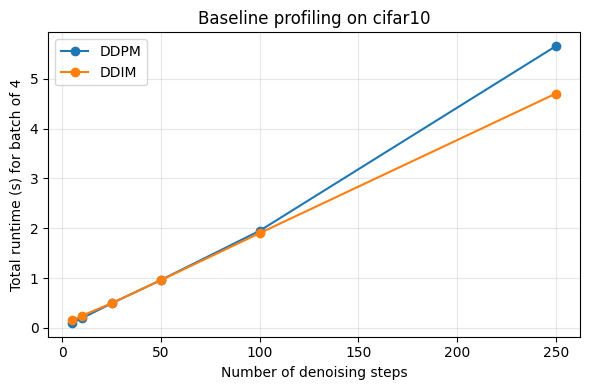


=== flowers ===

Loaded profiling data from: /content/drive/My Drive/Uni/MSGAI/Project: MSGAI/3_final project/logs/baseline_profiling_flowers.csv


,algo,steps,n_imgs,dataset,seed,total_s,per_step_ms
0,DDPM,5,4,flowers,42,0.144654,28.930807
1,DDPM,10,4,flowers,42,0.286712,28.671241
2,DDPM,25,4,flowers,42,0.698947,27.957869
3,DDPM,50,4,flowers,42,1.627673,32.553453
4,DDPM,100,4,flowers,42,3.312237,33.122370



Total runtime vs steps for DDPM and DDIM



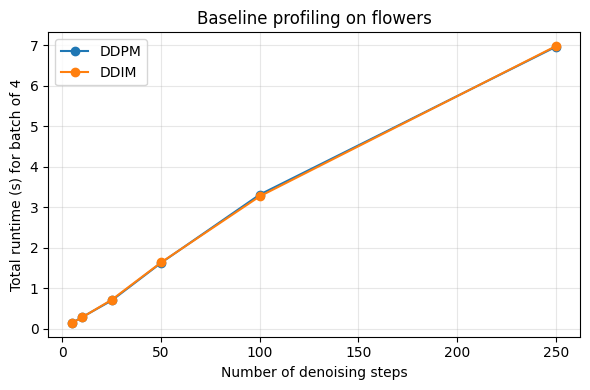


=== faces ===

Loaded profiling data from: /content/drive/My Drive/Uni/MSGAI/Project: MSGAI/3_final project/logs/baseline_profiling_faces.csv


,algo,steps,n_imgs,dataset,seed,total_s,per_step_ms
0,DDPM,5,4,faces,42,0.990003,198.000622
1,DDPM,10,4,faces,42,1.980625,198.062539
2,DDPM,25,4,faces,42,4.973176,198.927031
3,DDPM,50,4,faces,42,9.963362,199.267230
4,DDPM,100,4,faces,42,20.225987,202.259870



Total runtime vs steps for DDPM and DDIM



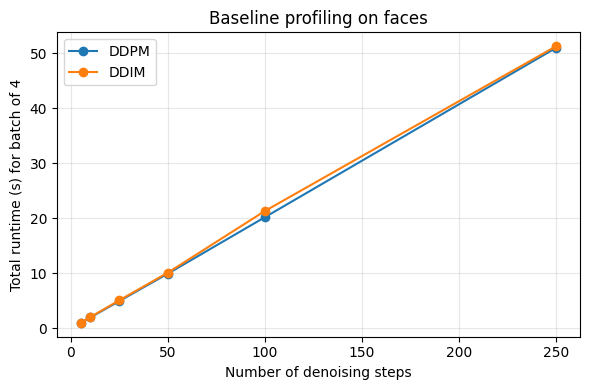

In [42]:
for dataset_key in DATASETS_INFO.keys():
  print(f"\n=== {dataset_key} ===\n")
  csv_path = f"{PROJECT_ROOT}/logs/baseline_profiling_{dataset_key}.csv"

  if not os.path.exists(csv_path):
      raise FileNotFoundError(f"Profiling CSV not found at {csv_path}.\nEither set RUN_PROFILING = True above or check PROJECT_ROOT.")

  df_profile = pd.read_csv(csv_path)
  print("Loaded profiling data from:", csv_path)
  display(df_profile.head())

  print("\nTotal runtime vs steps for DDPM and DDIM\n")
  plot_baseline_profiling(df_profile=df_profile, dataset_key=dataset_key, batch_size=4)

### 5.8 Output Interpretation

Figure 5 shows the baseline profiling results for DDPM and DDIM on CIFAR-10, Flowers, and Faces.
Across all datasets and both samplers, **total runtime scales approximately linearly with the number of denoising steps**, validating the service-time model

$$
S(n) \approx \alpha + \beta n.
$$

The key difference across datasets lies in the **slope $\beta$**, i.e., the per-step cost:

* **CIFAR-10** has the smallest slope (≈20 ms per step for a batch of 4), making it the least expensive workload.
* **Flowers** has a moderately larger slope (≈30 ms per step), reflecting higher per-step compute due to a larger model and image resolution.
* **Faces** exhibits a very steep slope (≈200 ms per step), dominating total service time even at modest step counts.

Within each dataset, **DDPM and DDIM have very similar slopes**, indicating that at equal step counts they incur comparable per-step costs. This confirms that DDIM’s advantage does not come from cheaper individual steps, but from achieving acceptable quality with **fewer steps**, which is exactly what early-exit policies exploit.

Overall, these results show that:

* step count is the primary driver of latency,
* per-step cost varies strongly across datasets,
* and reducing the number of steps is the most effective lever for controlling queueing delay.

These fitted slopes directly determine the behavior of the queueing system in later sections.


## 6. Service-Time Model Fit

### 6.1 Motivation

To embed diffusion sampling into a queueing-theoretic model, we need a **predictive formula** for how long a single request takes based on the number of denoising steps.

Each reverse diffusion step is **one UNet forward pass**, therefore total sampling time grows *approximately linearly* with the number of steps:

$$
S(n) \approx \alpha + \beta n.
$$

* $\alpha$ = fixed overhead (pipeline creation, memory allocations, scheduler setup).
* $\beta$ = per-step compute time (UNet forward pass).

This **linear service-time model** is the core of the *G* in our M/G/1 queue.

### 6.2 What This Section Does

For each dataset and each sampler:

* **Datasets:** CIFAR-10, Flowers-102, CelebA Faces
* **Sampling Algorithms:** DDPM and DDIM

we perform a **least-squares fit** of:

$$
\mathrm{time_{total}}(n) \approx \alpha + \beta n.
$$

The procedure:

1. Load the empirical runtime logs from Section 5
   (`baseline_profiling_<dataset>.csv`)
2. Extract measurements for each algorithm separately (DDPM, DDIM)
3. Fit $(\alpha, \beta)$ via linear regression
4. Optionally plot measured vs. fitted service times
5. Store results in: `FITS_ALL[dataset_key] = {"ddpm": (alpha_ddpm, beta_ddpm), "ddim": (alpha_ddim, beta_ddim)}`

These parameters become the **only timing input** to the queue simulator in Section 7.

### 6.3 Why This Step Is Essential

* All queueing behavior (waiting times, system stability, load sensitivity) depends on the **service-time distribution**.
* Policies in later sections choose:

  * which sampler to run (DDPM vs DDIM)
  * how many steps to run
* The simulator uses the fitted $S(n)$ model to compute:

  * per-job service time
  * server utilization
  * waiting and total latency

Without accurate $\alpha$ and $\beta$, latency predictions and policy comparisons would not reflect real system behavior.

### 6.4 Fit Service-Time Models for All Datasets

In [114]:
def fit_service_time_model(df_profile: pd.DataFrame, dataset_key: str, do_plot: bool = True):
    """
    Fit the service-time model S(n) = α + β·n separately for DDPM and DDIM.
    """
    algos = ["ddpm", "ddim"]
    fits = {}

    # filter for the active dataset
    df = df_profile[df_profile["dataset"] == dataset_key]

    if df.empty:
        raise ValueError(f"No profiling data for dataset '{dataset_key}'. Run profiling first.")

    for algo in algos:
        sub = df[df["algo"] == algo.upper()]
        if len(sub) == 0:
            print(f"[WARN] No profiling rows for algo: {algo}")
            continue

        # extract x=steps and y=total_time
        x = sub["steps"].values.astype(float)
        y = sub["total_s"].values.astype(float)

        # design matrix for linear fit y = α + β·x
        A = np.vstack([np.ones_like(x), x]).T

        # least squares
        alpha, beta = np.linalg.lstsq(A, y, rcond=None)[0]
        fits[algo] = (float(alpha), float(beta))

        print(f"Fitted {algo}: α={alpha:.4f}s, β={beta*1000:.3f} ms/step")

        # plot if requested
        if do_plot:
            x_grid = np.linspace(min(x), max(x), 50)
            y_hat = alpha + beta * x_grid

            plt.figure(figsize=(5, 4))
            plt.scatter(x, y, label="Measured", color="C0")
            plt.plot(x_grid, y_hat, label="Fitted", color="C1")
            plt.title(f"Service-time Fit: {algo} ({dataset_key})")
            plt.xlabel("Steps")
            plt.ylabel("Total runtime (s)")
            plt.legend()
            plt.grid(True)
            plt.show()
            save_path = f"{PROJECT_ROOT}/plots/service_time_fit_{algo}_{dataset_key}.png"
            plt.savefig(save_path, dpi=150)

    return fits


=== Fitting service-time model for cifar10 ===

Fitted ddpm: α=-0.1010s, β=22.654 ms/step


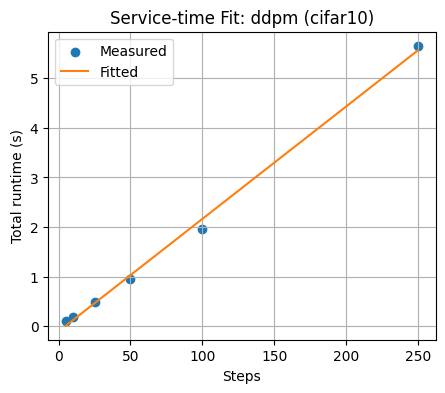

Fitted ddim: α=0.0461s, β=18.605 ms/step


<Figure size 640x480 with 0 Axes>

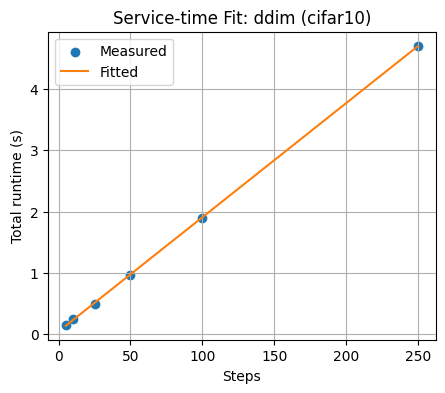


=== Fitting service-time model for flowers ===

Fitted ddpm: α=0.1173s, β=28.017 ms/step


<Figure size 640x480 with 0 Axes>

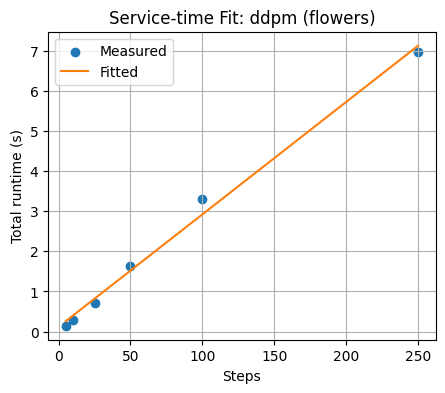

Fitted ddim: α=0.1146s, β=28.042 ms/step


<Figure size 640x480 with 0 Axes>

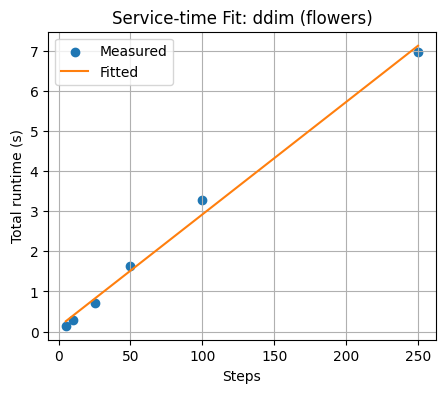


=== Fitting service-time model for faces ===

Fitted ddpm: α=-0.1288s, β=204.380 ms/step


<Figure size 640x480 with 0 Axes>

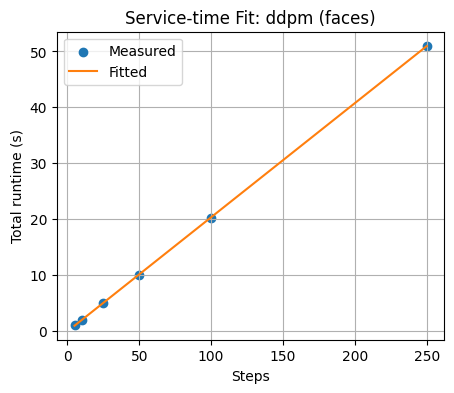

Fitted ddim: α=0.0736s, β=205.803 ms/step


<Figure size 640x480 with 0 Axes>

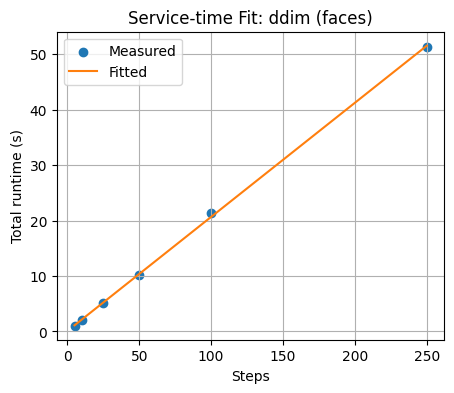

<Figure size 640x480 with 0 Axes>

In [115]:
FITS_ALL = {}

for dataset_key in DATASETS_INFO.keys():
    print(f"\n=== Fitting service-time model for {dataset_key} ===\n")
    df = pd.read_csv(f"{PROJECT_ROOT}/logs/baseline_profiling_{dataset_key}.csv")

    fits = fit_service_time_model(df_profile=df, dataset_key=dataset_key, do_plot=True)

    FITS_ALL[dataset_key] = fits

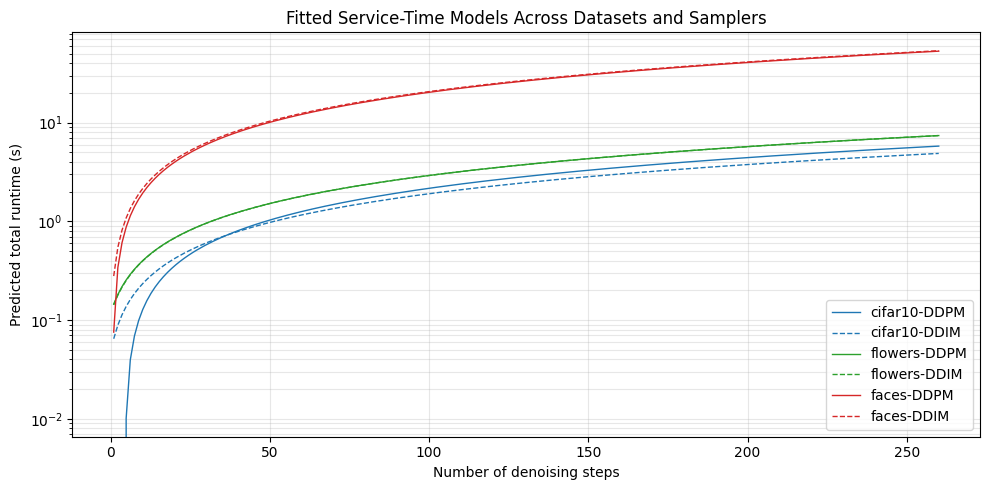

In [49]:
# Common step range
steps = np.linspace(1, 260, 200)  # start at 1 to avoid log(0)

# Color per dataset
dataset_colors = {"cifar10": "tab:blue", "flowers": "tab:green", "faces": "tab:red"}

# Linestyle per algorithm
algo_styles = {"ddpm": "-","ddim": "--"}

plt.figure(figsize=(10, 5))

for dataset_key, fits in FITS_ALL.items():
    for algo, (alpha, beta) in fits.items():
        service_time = alpha + beta * steps
        label = f"{dataset_key}-{algo.upper()}"
        plt.plot(steps, service_time, color=dataset_colors[dataset_key], linestyle=algo_styles[algo], linewidth=1, label=label)

plt.xlabel("Number of denoising steps")
plt.ylabel("Predicted total runtime (s)")
plt.title("Fitted Service-Time Models Across Datasets and Samplers")
plt.yscale("log")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


### 6.5 Output Interpretation (Service-Time Model Fit)

The fitted service-time curves show a clear linear dependence between total runtime and the number of denoising steps across all datasets and samplers, supporting the model

$$
S(n) \approx \alpha + \beta n.
$$

To make all datasets visible in a single figure, we plot the fitted models on a **logarithmic y-axis**. This is necessary because per-step costs differ by **more than an order of magnitude** between datasets; a linear scale would visually collapse smaller models (CIFAR-10, Flowers) when plotted alongside Faces.

The dominant signal is captured by the **slope $\beta$**, which represents per-step cost:

* **CIFAR-10:** smallest slopes (≈19–23 ms/step), with DDIM slightly cheaper per step than DDPM.
* **Flowers:** intermediate slopes (≈28 ms/step) and almost identical DDPM/DDIM behavior.
* **Faces:** very large slopes (≈200 ms/step), completely dominating service time; algorithm choice has only a minor effect relative to model scale.

Overall, these results show that **step count is the primary determinant of service time**, while DDPM vs DDIM differences are secondary. The large slope for Faces explains why queueing delay grows rapidly for this workload and motivates aggressive early-exit policies in later sections.


## 7. Queuing Model & Simulator: Poisson Arrivals • M/G/1 Queue • FIFO GPU Server

Up to now, diffusion sampling has been treated as an **isolated computation**:
given a choice of sampler and number of steps $(\text{algo}, n)$, we can measure how long one generation takes.

In a real serving system, however, requests do **not** arrive one at a time.
They arrive **over time**, compete for a **single GPU**, and must often **wait in a queue**.
As a result, end-to-end latency is determined not only by computation cost, but also by **queueing delay**.

This section builds a **virtual GPU server** that captures this behavior.
Requests arrive randomly, wait in line if the GPU is busy, and are served one-by-one according to a fixed diffusion configuration.
This simulator forms the backbone of all experiments in later sections.

### 7.1 Motivation: Why Queueing Theory?

Diffusion inference is expensive.
Even modest increases in arrival rate can cause:

* rapid queue buildup,
* GPU saturation,
* waiting times that dominate total latency,
* large performance differences between seemingly similar configurations.

We therefore want to answer a fundamental systems question:

> **How does diffusion inference latency behave under load, even when the computation itself is unchanged?**

Queueing theory provides a principled way to reason about this.

### 7.2 The M/G/1 Abstraction for Diffusion Serving

We model the system as a classical **M/G/1 queue**, where each component maps naturally to our setting.

#### M — Markovian (Poisson) arrivals

Requests arrive according to a **Poisson process** with rate $\lambda$ (jobs per second).
Equivalently, the time between two consecutive arrivals is a random variable:

$$
\Delta t \sim \text{Exp}(\lambda)
$$

Intuitively:

* arrivals are random,
* arrivals are independent,
* sometimes requests arrive close together, sometimes far apart.

This is a standard and widely used model for online traffic.

#### G — General service time

The service time of a job is **not constant**.
It depends on:

* which sampler is used (DDPM or DDIM),
* how many denoising steps $n$ are executed.

From Section 6, we approximate service time using a fitted linear model:

$$
S(n) \approx \alpha + \beta n
$$

The parameters $(\alpha, \beta)$ are dataset- and sampler-specific and are treated as known inputs to the simulator.

#### 1 — One server (one GPU)

We assume:

* a single GPU,
* only one job can run at a time,
* jobs are served in **FIFO order**.

All other jobs must wait until the GPU becomes free.

### 7.3 Latency Decomposition

For each request processed by the simulator, we record three timestamps:

* **arrival time** — when the request enters the system,
* **start time** — when the GPU begins processing it,
* **finish time** — when processing completes.

From these we compute:

* **waiting time**
  $$
  W = \text{start} - \text{arrival}
  $$

* **service time**
  $$
  S = \text{finish} - \text{start}
  $$

* **total response time**
  $$
  T = \text{finish} - \text{arrival}
  $$

Under load, waiting time often becomes the dominant contributor to total latency.
This decomposition lets us see exactly *where* time is being spent.

### 7.4 Simulator Implementation

The simulator is event-driven and implements exactly the M/G/1 model described above.

**Job representation**

Each completed request is stored as a `JobRecord`:

In [64]:
@dataclass
class JobRecord:
    arrival: float
    start: float
    finish: float
    algo: str
    steps: int
    policy: str = ""  # name of the policy function used

**Core simulator function**

The function `simulate_queue(...)` performs the following steps repeatedly until a fixed time horizon is reached:

1. Sample the next inter-arrival time from an exponential distribution.
2. Determine how many jobs are currently still in the system (queue length).
3. Select a **fixed diffusion configuration** (algorithm and steps).
4. Compute service time using $S(n) = \alpha + \beta n$.
5. Schedule the job on the GPU using FIFO logic.
6. Record arrival, start, and finish times.

The output is a list of `JobRecord`s representing all jobs processed during the simulation window.

In [65]:
def simulate_queue(lambda_rate: float, horizon_s: float, policy_fn: Callable[[int], Tuple[str, int]], fits: Dict[str, Tuple[float, float]], rng: Optional[random.Random] = None) -> List[JobRecord]:
    """
    Simulate a single-server FIFO queue with Poisson arrivals (M/G/1-style).
    """
    if rng is None:
        rng = random.Random(SEED)

    results: List[JobRecord] = []
    t = 0.0               # current time
    server_free_at = 0.0  # when the server will be free next

    while t < horizon_s:
        # 1) Sample next inter-arrival time: Exp(λ)
        t += rng.expovariate(lambda_rate)
        arrival = t

        # 2) Queue length = number of jobs still in system at arrival
        qlen = sum(1 for r in results if r.finish > arrival)

        # 3) Policy chooses algorithm + number of steps based on qlen
        algo, steps = policy_fn(qlen)

        # 4) Service time from fitted S(n) = α + β n
        alpha, beta = fits[algo.lower()]
        service_time = alpha + beta * steps

        # 5) Start time: either now, or when the current job finishes
        start = max(arrival, server_free_at)
        finish = start + service_time
        server_free_at = finish

        # 6) Record job
        results.append(JobRecord(arrival=arrival, start=start, finish=finish, algo=algo, steps=steps, policy=policy_fn.__name__))

    return results

### 7.5 Fixed Policies Used for Validation

In this section, we deliberately **do not use adaptive policies yet**.
Instead, we validate the simulator using simple, fixed baselines. These policies:

* ignore queue length,
* always choose the same computation,
* serve as controlled reference points.

In [66]:
def fixed_ddpm_100(qlen: int) -> Tuple[str, int]:
    """Baseline: always use DDPM with 100 steps, independent of queue length."""
    return ("ddpm", 100)

def fixed_ddim_50(qlen: int) -> Tuple[str, int]:
    """Baseline: always use DDIM with 50 steps."""
    return ("ddim", 50)

def fixed_ddim_20(qlen: int) -> Tuple[str, int]:
    """Baseline: always use DDIM with 20 steps."""
    return ("ddim", 20)

### 7.6 Summary Statistics

The helper function `summarize_jobs(...)` aggregates simulator output into interpretable metrics:

* number of jobs processed,
* mean waiting time,
* mean service time,
* mean total latency,
* 95th-percentile waiting and total latency.

These summaries are the primary outputs used in later experiments.

In [67]:
def summarize_jobs(results: List[JobRecord]) -> Dict[str, float]:
    """Compute basic latency stats from a list of JobRecord."""
    waits = [r.start  - r.arrival for r in results]
    service = [r.finish - r.start for r in results]
    total = [r.finish - r.arrival for r in results]

    return {"n": len(results), "wait_mean": float(np.mean(waits)), "srv_mean": float(np.mean(service)), "tot_mean": float(np.mean(total)), "wait_p95": float(np.percentile(waits, 95)), "tot_p95": float(np.percentile(total, 95))}

### 7.7 Smoke Test: End-to-End Validation

Finally, we run the simulator for all datasets and multiple arrival rates using only the **fixed baselines**.

This smoke test verifies that:

* Poisson arrivals are generated correctly,
* FIFO scheduling is respected,
* fitted service-time models are applied correctly,
* waiting time increases with load,
* faster configurations reduce queueing delay even without adaptation.

At this point, we have a **fully validated queueing simulator**.

In [68]:
TEST_LAMBDAS = [0.3, 0.6, 0.9]  # low and medium load
HORIZON_S    = 60.0        # simulate 60 seconds per run
POLICIES = {"fixed_ddpm_100": fixed_ddpm_100, "fixed_ddim_50": fixed_ddim_50, "fixed_ddim_20": fixed_ddim_20}

for dataset_key in DATASETS_INFO.keys():
    print(f"\n================ Dataset: {dataset_key} ================\n")

    if dataset_key not in FITS_ALL:
        raise KeyError(f"No FITS found for dataset '{dataset_key}'. Make sure Section 6 (fit_service_time_model) ran successfully.")

    fits = FITS_ALL[dataset_key]  # e.g. {'ddpm': (α,β), 'ddim': (α,β)}

    for lam in TEST_LAMBDAS:
        print(f"--- Arrival rate λ = {lam:.2f} jobs/s ---")

        for policy_name, policy_fn in POLICIES.items():
            results = simulate_queue(lambda_rate=lam, horizon_s=HORIZON_S, policy_fn=policy_fn, fits=fits)
            stats = summarize_jobs(results)
            print(
                f"{policy_name:>14} | "
                f"n ={stats['n']:3d} | "
                f"wait_mean = {stats['wait_mean']:.3f}s | "
                f"srv_mean = {stats['srv_mean']:.3f}s | "
                f"tot_mean = {stats['tot_mean']:.3f}s"
            )
        print()  # blank line between λ values


================ Dataset: cifar10 ================

--- Arrival rate λ = 0.30 jobs/s ---
fixed_ddpm_100 | n = 25 | wait_mean = 4.007s | srv_mean = 2.164s | tot_mean = 6.171s
 fixed_ddim_50 | n = 25 | wait_mean = 0.349s | srv_mean = 0.976s | tot_mean = 1.325s
 fixed_ddim_20 | n = 25 | wait_mean = 0.060s | srv_mean = 0.418s | tot_mean = 0.478s

--- Arrival rate λ = 0.60 jobs/s ---
fixed_ddpm_100 | n = 39 | wait_mean = 17.399s | srv_mean = 2.164s | tot_mean = 19.564s
 fixed_ddim_50 | n = 39 | wait_mean = 0.995s | srv_mean = 0.976s | tot_mean = 1.972s
 fixed_ddim_20 | n = 39 | wait_mean = 0.103s | srv_mean = 0.418s | tot_mean = 0.521s

--- Arrival rate λ = 0.90 jobs/s ---
fixed_ddpm_100 | n = 62 | wait_mean = 38.673s | srv_mean = 2.164s | tot_mean = 40.837s
 fixed_ddim_50 | n = 62 | wait_mean = 3.343s | srv_mean = 0.976s | tot_mean = 4.319s
 fixed_ddim_20 | n = 62 | wait_mean = 0.259s | srv_mean = 0.418s | tot_mean = 0.677s


================ Dataset: flowers ================

--- Arrival

### 7.8 Output Interpretation

The tables below report **mean latency statistics** under Poisson arrivals for three *fixed* baseline policies:

* **DDPM-100** — slow, high-quality
* **DDIM-50** — medium speed
* **DDIM-20** — very fast, low compute

All values are averages over a 60-second simulation horizon.

---

**CIFAR-10 — Mean Latency (seconds)**

| λ (jobs/s) | Policy   | Jobs | Mean wait | Mean service | Mean total |
| ---------: | -------- | ---: | --------: | -----------: | ---------: |
|       0.30 | DDPM-100 |   25 |      4.01 |         2.16 |       6.17 |
|            | DDIM-50  |   25 |      0.35 |         0.98 |       1.33 |
|            | DDIM-20  |   25 |      0.06 |         0.42 |       0.48 |
|       0.60 | DDPM-100 |   39 |     17.40 |         2.16 |      19.56 |
|            | DDIM-50  |   39 |      1.00 |         0.98 |       1.97 |
|            | DDIM-20  |   39 |      0.10 |         0.42 |       0.52 |
|       0.90 | DDPM-100 |   62 |     38.67 |         2.16 |      40.84 |
|            | DDIM-50  |   62 |      3.34 |         0.98 |       4.32 |
|            | DDIM-20  |   62 |      0.26 |         0.42 |       0.68 |

---

**Flowers — Mean Latency (seconds)**

| λ (jobs/s) | Policy   | Jobs | Mean wait | Mean service | Mean total |
| ---------: | -------- | ---: | --------: | -----------: | ---------: |
|       0.30 | DDPM-100 |   25 |      9.44 |         2.92 |      12.35 |
|            | DDIM-50  |   25 |      1.30 |         1.52 |       2.81 |
|            | DDIM-20  |   25 |      0.16 |         0.68 |       0.84 |
|       0.60 | DDPM-100 |   39 |     31.74 |         2.92 |      34.66 |
|            | DDIM-50  |   39 |      5.12 |         1.52 |       6.63 |
|            | DDIM-20  |   39 |      0.32 |         0.68 |       0.99 |
|       0.90 | DDPM-100 |   62 |     61.69 |         2.92 |      64.61 |
|            | DDIM-50  |   62 |     18.92 |         1.52 |      20.43 |
|            | DDIM-20  |   62 |      1.02 |         0.68 |       1.70 |

---

**Faces — Mean Latency (seconds)**

| λ (jobs/s) | Policy   | Jobs | Mean wait | Mean service | Mean total |
| ---------: | -------- | ---: | --------: | -----------: | ---------: |
|       0.30 | DDPM-100 |   25 |    218.03 |        20.31 |     238.34 |
|            | DDIM-50  |   25 |     98.68 |        10.36 |     109.05 |
|            | DDIM-20  |   25 |     24.59 |         4.19 |      28.78 |
|       0.60 | DDPM-100 |   39 |    362.15 |        20.31 |     382.46 |
|            | DDIM-50  |   39 |    173.19 |        10.36 |     183.55 |
|            | DDIM-20  |   39 |     55.88 |         4.19 |      60.07 |
|       0.90 | DDPM-100 |   62 |    592.09 |        20.31 |     612.40 |
|            | DDIM-50  |   62 |    288.75 |        10.36 |     299.12 |
|            | DDIM-20  |   62 |    100.44 |         4.19 |     104.63 |

---

**Interpretation**

These results validate the **queue simulator end-to-end**.

Across all datasets and arrival rates, the same pattern emerges:

* **Service time is fixed by the policy**, but
* **waiting time grows rapidly with load**, especially for slow policies.

Key observations:

* **DDPM-100** quickly becomes impractical: long service times block the GPU, causing the queue (and waiting time) to explode.
* **DDIM-50** substantially reduces service time and therefore limits queue growth, but still accumulates large delays at high λ.
* **DDIM-20** keeps service times extremely short, preventing queue buildup even near saturation — at the cost of reduced generation quality.

The effect is most dramatic for **Faces**, where per-step cost is high: even moderate arrival rates push slow policies deep into congestion.

Overall, this section shows that:

1. **Queueing delay dominates end-to-end latency under load**.
2. **Small reductions in service time lead to large reductions in waiting time**.
3. The simulator correctly captures Poisson arrivals, FIFO execution, and fitted service times.

This establishes a clean baseline.
In **Section 8**, we will introduce **queue-aware policies** that *adaptively move between these fixed operating points* instead of committing to one upfront.


## 8. Queue-Aware Early-Exit Mechanism

Sections 5–6 showed that diffusion **service time scales linearly** with the number of denoising steps,

$$
S(n) \approx \alpha + \beta n,
$$

and Section 7 demonstrated how this service time interacts with **Poisson arrivals** to create queueing delay on a single GPU server.

A key takeaway from Section 7 was:

> **Small reductions in service time can lead to very large reductions in waiting time once the system is under load.**

This section turns that observation into a **mechanism**.

Rather than treating diffusion sampling as a fixed-cost operation, we now **adapt the computation itself** based on instantaneous congestion, using the queue length as a signal. This is the central contribution of the project.

### 8.1 From Measurement to Mechanism

Section 7 deliberately used **only fixed policies** (DDPM-100, DDIM-50, DDIM-20).
That section answered the question:

> *“What happens to latency if we keep computation fixed while load increases?”*

The answer was clear:

* waiting time dominates latency,
* long service times cause queues to explode,
* faster samplers dramatically stabilize the system.

**Section 8 answers the next question:**

> *“Given what we observed, how should the system adapt its computation online?”*

Instead of committing to one fixed operating point, we allow the system to **change `(algo, steps)` per job**, based on how congested the server currently is.

### 8.2 Intuition: Why Queue Length?

Queue length is a natural and lightweight congestion signal:

* it is **locally observable** at the server,
* it directly reflects whether jobs are waiting,
* it requires no prediction of future arrivals.

From Section 7, we observed that:

* when the queue is small, waiting time is negligible and latency is dominated by service time,
* once the queue grows, waiting time increases rapidly,
* reducing service time under congestion yields **disproportionately large latency gains**.

This motivates a **tiered response** to load:

| Queue state | Dominant cost | Best action                      |
| ----------- | ------------- | -------------------------------- |
| Low load    | Quality       | Use slow, high-quality sampling  |
| Medium load | Service time  | Reduce steps moderately          |
| High load   | Waiting time  | Aggressively shorten computation |

Queue length therefore provides exactly the signal needed to decide **how much computation the system can afford at a given moment**.

### 8.3 Three-Level Early-Exit Policy

We operationalize this intuition using a simple **three-level early-exit policy**.

**Thresholds**

We introduce two queue-length thresholds:

* $T_1$ — transition from low to medium load
* $T_2$ — transition from medium to high load, with $T_2 > T_1$

For all experiments, we start with:

* $T_1 = 2$: jobs are beginning to queue
* $T_2 = 5$: the system is clearly congested

These values are deliberately conservative and interpretable: they trigger adaptation early enough to prevent runaway queue growth, while still allowing high-quality sampling when the system is lightly loaded. Their sensitivity is analyzed later in **Section 10 (Ablations)**.

**Step budgets and algorithms**

We define three computation levels:

* $k_{\text{full}} = 100$ — full-quality sampling
* $k_{\text{med}} = 50$ — moderate cost
* $k_{\text{short}} = 20$ — minimal cost

We pair them with algorithms as follows:

* **DDPM-100** at low load
  → best quality when latency pressure is low
* **DDIM-50** at medium load
  → good quality with substantially lower service time
* **DDIM-20** at high load
  → aggressive cost reduction to prevent queue explosion

This choice is grounded in the profiling results from Section 5:
DDIM offers little advantage over DDPM at large step counts, but is **much more effective when the number of steps is aggressively reduced**.

### 8.4 Policy Definition

The resulting policy maps queue length $q$ to a sampler configuration:

$$
(\text{algo}, k) =
\begin{cases}
(\text{DDIM}, k_{\text{short}}) & q \ge T_2, \\
(\text{DDIM}, k_{\text{med}})   & q \ge T_1, \\
(\text{DDPM}, k_{\text{full}})  & q < T_1.
\end{cases}
$$

Interpretation:

* **Low load** → maximize image quality
* **Medium load** → reduce cost cautiously
* **High load** → prioritize responsiveness

This policy is intentionally simple: it uses only queue length, requires no forecasting, and integrates directly with the M/G/1 simulator from Section 7. Sections 9 and 10 evaluate how this mechanism affects latency–quality trade-offs and how sensitive it is to the chosen thresholds and step budgets.


### 8.5 Implementation and Integration

The policy is implemented as a pure function. This function is queried **for every arriving job** inside the queue simulator:

1. a job arrives,
2. current queue length $q$ is computed,
3. the policy selects `(algo, steps)` for *that job only*,
4. service time is computed using
   $$
   S(n) = \alpha + \beta n,
   $$
5. the job is scheduled on the GPU.

Importantly:

* the policy is **not applied once globally**,
* it does **not decide for a whole batch of images**,
* it decides **per job**, at arrival time.

A “job” in the simulator corresponds to **one diffusion request** (which internally may generate a small batch of images, e.g. 4).
All images in that request share the same `(algo, steps)`, but different jobs may use different configurations depending on queue state.

In [69]:
def policy_3level(qlen: int, T1: int = 2, T2: int = 5, k_full: int = 100, k_med: int = 50, k_short: int = 20, algo_full: str = "ddpm", algo_reduced: str = "ddim") -> tuple[str, int]:
    """
    Three-level queue-aware early-exit policy.
    """

    # High load → shortest DDIM
    if qlen >= T2:
        return algo_reduced, k_short

    # Medium load → medium DDIM
    if qlen >= T1:
        return algo_reduced, k_med

    # Low load → full DDPM
    return algo_full, k_full

In [70]:
def policy_3level_wrapper(qlen: int) -> tuple[str, int]:
    """
    Wrapper that fixes thresholds and step budgets for our experiments.
    This function matches the simulator signature: policy_fn(qlen) -> (algo, steps)
    """
    return policy_3level(qlen=qlen, T1=2, T2=5, k_full=100, k_med=50, k_short=20, algo_full="ddpm", algo_reduced="ddim")

### 8.4 Quick Demonstration

Evaluating the wrapper for different queue lengths:

In [63]:
for q in [0, 1, 2, 5, 8]:
    print(f"qlen={q:2d} → {policy_3level_wrapper(q)}")

qlen= 0 → ('ddpm', 100)
qlen= 1 → ('ddpm', 100)
qlen= 2 → ('ddim', 50)
qlen= 5 → ('ddim', 20)
qlen= 8 → ('ddim', 20)


This confirms the expected transitions between full DDPM → medium DDIM → short DDIM as load increases.

### 8.6 What This Enables

This mechanism connects everything built so far:

* Section 5–6: measured how $(\alpha, \beta)$ differ by dataset and sampler
* Section 7: showed how service time interacts with queueing delay
* **Section 8**: turns those observations into a concrete control policy

In the next sections:

* **Section 9 (Experiments)** evaluates how this adaptive policy changes:

  * waiting time,
  * total latency,
  * effective image quality,
    under different arrival rates.
* **Section 10 (Ablations)** studies how sensitive performance is to:

  * threshold placement $(T_1, T_2)$,
  * step budgets $(k_{\text{full}}, k_{\text{med}}, k_{\text{short}})$,
  * algorithm switching (DDPM vs DDIM).

Together, these sections quantify **when and why queue-aware early exit is beneficial**, and how robust the mechanism is across workloads.

---

## 9. Experiments: Latency–Quality Evaluation

Section 8 defines a **queue-aware policy** that changes `(algo, steps)` depending on how congested the system is.
Section 9 answers the practical question: **Does this actually help, and what do we give up in quality?**

We evaluate along two axes:

* **Latency under load:** as the arrival rate $\lambda$ increases, does the policy prevent queueing delay from exploding?
* **Quality vs latency:** when the policy “early-exits” (fewer steps / DDIM), how much quality do users lose?

All experiments run **for every dataset** in `DATASETS_INFO`, and write reproducible logs to `{PROJECT_ROOT}/logs/`. The figures saved in `{PROJECT_ROOT}/plots/` are the report-ready summaries.

#### **Overview of experiment outputs**

This section produces three CSV logs, each answering a different piece of the story:

* `latency_experiments.csv`
  **Queueing outcome:** mean waiting/service/total latency (with 95% CIs) for each `(dataset, lambda, policy)`.

* `quality_grid_<dataset>.csv`
  **Per-configuration quality:** CLIPScore and FID for the specific sampler settings that policies may choose (e.g., DDPM-100, DDIM-50, DDIM-20).

* `policy_quality_summary.csv`
  **Policy-level user experience:** combines (i) how often a policy uses each configuration under a given $\lambda$, with (ii) the offline quality of those configurations, to estimate the *effective* quality users receive.

### 9.1 Experiment 1: Latency vs Load with Confidence Intervals

We take the simulator from Section 7 (Poisson arrivals + FIFO GPU + service times from $S(n)=\alpha+\beta n$) and “stress test” it: we crank up the arrival rate $\lambda$ and see how each policy behaves. This isolates the **system-level effect** of early-exit: shorter jobs don’t just finish earlier — they also prevent long queues from forming.

**What happens (mechanically).**   

* Choose arrival rates $\lambda \in {0.3, 0.6, 0.9}$ jobs/s and a horizon $H = 60$s.
* For each `(dataset, lambda, policy)`:

  * Run $R=5$ independent simulations (different RNG seeds).
  * In each run, compute mean waiting time, mean service time, and mean total time across jobs.
  * Aggregate across runs and report a mean + **95% confidence interval** (normal approximation on run-level means).

**Why it matters.**   
This gives the core queueing result: whether the adaptive mechanism actually reduces *end-to-end* latency under load (mostly by cutting **waiting time**, not just service time).

Output: `latency_experiments.csv`.

In [77]:
# helper
def mean_and_ci(values, alpha: float = 0.05):
    """
    Compute mean and (1-alpha) confidence interval using a normal approximation.
    values: 1D array-like (e.g. run-level means)
    """
    vals = np.asarray(values, dtype=float)
    m = float(vals.mean())
    s = float(vals.std(ddof=1)) if len(vals) > 1 else 0.0
    if len(vals) <= 1:
        # CI collapses to the mean if only one run
        return m, m, m
    z = 1.96  # approx for 95% CI
    half_width = z * s / np.sqrt(len(vals))
    return m, m - half_width, m + half_width

In [79]:
LAMBDA_GRID = [0.3, 0.6, 0.9]     # low, medium, high load
HORIZON_S = 60.0                  # simulation horizon (seconds)
N_RUNS = 5                        # independent runs per (dataset, λ, policy)

POLICIES = {"fixed_ddpm_100": fixed_ddpm_100, "fixed_ddim_50": fixed_ddim_50, "fixed_ddim_20": fixed_ddim_20, "policy_3level": policy_3level}

latency_rows = []

for dataset_key, fits in FITS_ALL.items():
    print(f"\n=== Latency experiment on dataset: {dataset_key} ===")

    for lam in LAMBDA_GRID:
        for policy_name, policy_fn in POLICIES.items():
            wait_means = []
            srv_means = []
            tot_means = []
            n_jobs = []

            # Multiple independent runs
            for run_idx in range(N_RUNS):
                rng = random.Random(SEED + run_idx)  # different seed per run
                results = simulate_queue(lambda_rate=lam, horizon_s=HORIZON_S, policy_fn=policy_fn, fits=fits, rng=rng)

                # Per-run summary
                waits = [r.start  - r.arrival for r in results]
                service = [r.finish - r.start for r in results]
                total = [r.finish - r.arrival for r in results]

                wait_means.append(np.mean(waits))
                srv_means.append(np.mean(service))
                tot_means.append(np.mean(total))
                n_jobs.append(len(results))

            # Run-level CI
            wait_m, wait_lo, wait_hi = mean_and_ci(wait_means)
            srv_m, srv_lo, srv_hi = mean_and_ci(srv_means)
            tot_m, tot_lo, tot_hi = mean_and_ci(tot_means)
            n_mean = float(np.mean(n_jobs))

            print(
                f"[{dataset_key}] λ={lam:.2f}, policy={policy_name:>14} | "
                f"jobs={n_mean:5.1f} | "
                f"wait_mean={wait_m:.3f}s (95% CI [{wait_lo:.3f}, {wait_hi:.3f}]) | "
                f"srv_mean={srv_m:.3f}s (95% CI [{srv_lo:.3f}, {srv_hi:.3f}]) | "
                f"tot_mean={tot_m:.3f}s (95% CI [{tot_lo:.3f}, {tot_hi:.3f}])"
            )

            latency_rows.append({"dataset": dataset_key, "lambda": lam, "policy": policy_name, "n_jobs_mean": n_mean, "wait_mean": wait_m, "wait_ci_lo": wait_lo, "wait_ci_hi": wait_hi, "srv_mean": srv_m, "srv_ci_lo": srv_lo, "srv_ci_hi": srv_hi, "tot_mean": tot_m, "tot_ci_lo": tot_lo, "tot_ci_hi": tot_hi,})

# Collect into DataFrame and save
df_latency = pd.DataFrame(latency_rows)
latency_csv_path = f"{PROJECT_ROOT}/logs/latency_experiments.csv"
df_latency.to_csv(latency_csv_path, index=False)
print(f"\nSaved latency experiment results → {latency_csv_path}")

display(df_latency.head())


=== Latency experiment on dataset: cifar10 ===
[cifar10] λ=0.30, policy=fixed_ddpm_100 | jobs= 22.8 | wait_mean=2.592s (95% CI [1.159, 4.024]) | srv_mean=2.164s (95% CI [2.164, 2.164]) | tot_mean=4.756s (95% CI [3.323, 6.189])
[cifar10] λ=0.30, policy= fixed_ddim_50 | jobs= 22.8 | wait_mean=0.387s (95% CI [0.179, 0.594]) | srv_mean=0.976s (95% CI [0.976, 0.976]) | tot_mean=1.363s (95% CI [1.156, 1.570])
[cifar10] λ=0.30, policy= fixed_ddim_20 | jobs= 22.8 | wait_mean=0.058s (95% CI [0.028, 0.088]) | srv_mean=0.418s (95% CI [0.418, 0.418]) | tot_mean=0.476s (95% CI [0.446, 0.506])
[cifar10] λ=0.30, policy= policy_3level | jobs= 22.8 | wait_mean=1.250s (95% CI [0.849, 1.652]) | srv_mean=1.811s (95% CI [1.661, 1.961]) | tot_mean=3.061s (95% CI [2.801, 3.322])
[cifar10] λ=0.60, policy=fixed_ddpm_100 | jobs= 39.4 | wait_mean=14.340s (95% CI [10.225, 18.455]) | srv_mean=2.164s (95% CI [2.164, 2.164]) | tot_mean=16.504s (95% CI [12.389, 20.620])
[cifar10] λ=0.60, policy= fixed_ddim_50 | jobs

,dataset,lambda,policy,n_jobs_mean,wait_mean,wait_ci_lo,wait_ci_hi,srv_mean,srv_ci_lo,srv_ci_hi,tot_mean,tot_ci_lo,tot_ci_hi
0,cifar10,0.3,fixed_ddpm_100,22.8,2.591618,1.158862,4.024374,2.164393,2.164393,2.164393,4.756012,3.323256,6.188767
1,cifar10,0.3,fixed_ddim_50,22.8,0.386728,0.179494,0.593961,0.976398,0.976398,0.976398,1.363126,1.155892,1.570359
2,cifar10,0.3,fixed_ddim_20,22.8,0.057768,0.027741,0.087794,0.418247,0.418247,0.418247,0.476015,0.445989,0.506041
3,cifar10,0.3,policy_3level,22.8,1.250211,0.848875,1.651547,1.811217,1.661425,1.961009,3.061427,2.800962,3.321892
4,cifar10,0.6,fixed_ddpm_100,39.4,14.340103,10.225027,18.455178,2.164393,2.164393,2.164393,16.504496,12.389420,20.619572


---

**Interpretation**

The table `latency_experiments.csv` reports mean waiting time, service time, and total latency (with 95% confidence intervals) for each policy as the arrival rate $\lambda$ increases. Across all datasets, a clear queueing pattern emerges: as load grows, **waiting time—not service time—quickly becomes the dominant contributor to end-to-end latency**. Fixed DDPM-100 performs worst under load because its long service time pushes the system toward high utilization, causing waiting times to explode (e.g., hundreds of seconds for Faces at $\lambda=0.9$). Fixed DDIM-50 substantially reduces service time and therefore limits queue growth, but still accumulates significant waiting at higher $\lambda$. Fixed DDIM-20 represents the extreme low-latency baseline: it achieves very small waiting times even at high load, at the cost of always operating in a low-compute regime.

The **queue-aware 3-level policy** consistently lies between these fixed extremes. At low load, it behaves closer to DDPM-100, incurring higher service time but still modest waiting. As $\lambda$ increases, it shifts toward faster configurations, reducing service time and preventing queue collapse. This effect is especially visible at $\lambda=0.9$, where the adaptive policy reduces total latency by factors of $5\text{–}10\times$ compared to DDPM-100 across datasets. The widening confidence intervals for slow fixed policies further indicate unstable queue dynamics near saturation, while the adaptive policy maintains tighter variability by actively controlling service time. Overall, this experiment confirms that **adaptive reduction of service time under congestion is critical for stabilizing latency in diffusion serving systems**.


---


### 9.2 Experiment 2: Offline Quality Grid per Dataset

Queue simulations don’t generate real images — they only predict timing. So we separately measure the **image quality** of the sampler configurations that the policies might use. We can think of this as a “calibration table”: *If we pick DDIM-20, what quality do we typically get?*

**What happens (mechanically).**   

For each dataset and each configuration used by policies (e.g. `(ddpm,100)`, `(ddim,50)`, `(ddim,20)`):

* Collect real images: $N_\text{real}=512$ from the dataset loader (in `[-1,1]`).
* Generate fake images: $N_\text{fake}=512$ using `generate()` (in `[0,1]`).
* Compute:

  * **CLIPScore** (mean + std): fast proxy for coherence.
  * **FID**: distributional distance vs real images (lower is better).

**Why it matters.**   
This isolates “quality vs compute” **without any queueing effects**. Later, when a policy mixes configurations under load, we can map its choices back to quality.

Output: `quality_grid_<dataset>.csv`.

**Helper: collect a fixed number of real images per dataset**

In [80]:
def collect_real_images(dataset_key: str, n_real: int = 512) -> torch.Tensor:
    """
    Collect up to n_real real images from the *train* loader of a dataset.
    Returned tensor is in [-1,1], shape [N,3,H,W].
    """
    train_loader, _ = get_dataloaders(dataset_key, batch_size=64)
    imgs_list = []
    for batch_imgs, _ in train_loader:
        imgs_list.append(batch_imgs.cpu())
        if sum(len(x) for x in imgs_list) >= n_real:
            break
    real_imgs = torch.cat(imgs_list, dim=0)[:n_real]   # stays on CPU, in [-1,1]
    return real_imgs


**Build quality grid: per (dataset, algo, steps) CLIP & FID**

In [81]:
def build_quality_grid(dataset_key: str, quality_configs: List[Tuple[str, int]] = [("ddpm", 100), ("ddim", 50), ("ddim", 20)], n_real: int = 512, n_fake: int = 512, fake_batch: int = 32, clip_batch: int = 32, fid_batch: int = 32, seed: int = 42, device: Optional[torch.device] = None, project_root: str = ".", save_csv: bool = True, verbose: bool = True) -> pd.DataFrame:
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if verbose:
        print(f"\n=== Building quality grid for dataset: {dataset_key} ===")

    # 1) Collect real images once
    real_imgs = collect_real_images(dataset_key, n_real=n_real)

    quality_rows = []

    for algo, steps in quality_configs:
        if verbose:
            print(f"  → Evaluating quality for ({algo.upper()}, steps={steps})")

        # 2) Generate fake images in chunks (store on CPU to avoid GPU accumulation)
        fake_list = []
        remaining = n_fake
        gen_seed = seed

        while remaining > 0:
            bs = min(fake_batch, remaining)
            gen_seed += 1  # vary seed so samples differ
            fake_batch_tensor, _ = generate(algo=algo, steps=steps, n_imgs=bs, dataset_key=dataset_key, seed=gen_seed, device=device, log_run=False)
            fake_list.append(fake_batch_tensor.detach().cpu())
            remaining -= bs

            # free GPU memory from the batch tensor as soon as possible
            del fake_batch_tensor
            if device.type == "cuda":
                torch.cuda.empty_cache()

        fake_imgs = torch.cat(fake_list, dim=0)  # CPU, [n_fake,3,H,W] in [0,1]
        del fake_list
        if device.type == "cuda":
            torch.cuda.empty_cache()

        # 3) CLIPScore (move to GPU in batches inside compute_clipscores)
        clip_scores, clip_mean = compute_clipscores(fake_imgs.to(device, non_blocking=True), device=device, batch_size=clip_batch)
        clip_std = float(np.std(clip_scores))

        # 4) FID (streaming update in small batches to avoid OOM)
        fid_metric = initialize_fid_metric(device)
        update_fid_metric(fid_metric, real_imgs=real_imgs, fake_imgs=fake_imgs, device=device, batch_size=fid_batch)
        fid_val = compute_final_fid(fid_metric)

        if verbose:
            print(f"     CLIP mean={clip_mean:.3f} (std={clip_std:.3f}), FID={fid_val:.2f}")

        quality_rows.append({"dataset": dataset_key, "algo": str(algo).lower(), "steps": int(steps), "n_real": int(n_real), "n_fake": int(n_fake), "clip_mean": float(clip_mean), "clip_std": float(clip_std), "fid": float(fid_val)})

        # 5) Free memory between configs
        del fid_metric
        del fake_imgs
        if device.type == "cuda":
            torch.cuda.empty_cache()

    df_q = pd.DataFrame(quality_rows)

    # 6) Save CSV
    if save_csv:
        os.makedirs(f"{project_root}/logs", exist_ok=True)
        q_csv_path = f"{project_root}/logs/quality_grid_{dataset_key}.csv"
        df_q.to_csv(q_csv_path, index=False)
        if verbose:
            print(f"Saved quality grid for {dataset_key} → {q_csv_path}")

    # 7) Display head for quick check
    display(df_q.head())

    return df_q

**Separating the runs for the different datasets for memory-reasons**

In [ ]:
# cifar10
torch.cuda.empty_cache()
df_cifar10 = build_quality_grid(dataset_key="cifar10", n_real=512, n_fake=512, fake_batch=32, clip_batch=32, fid_batch=32, seed=SEED, device=device, project_root=PROJECT_ROOT)


=== Building quality grid for dataset: cifar10 ===
  → Evaluating quality for (DDPM, steps=100)
     CLIP mean=0.217 (std=0.010), FID=173.19
  → Evaluating quality for (DDIM, steps=50)
     CLIP mean=0.222 (std=0.007), FID=87.57
  → Evaluating quality for (DDIM, steps=20)
     CLIP mean=0.224 (std=0.007), FID=94.87
Saved quality grid for cifar10 → /content/drive/My Drive/Uni/MSGAI/Project: MSGAI/3_final project//logs/quality_grid_cifar10.csv


,dataset,algo,steps,n_real,n_fake,clip_mean,clip_std,fid
0,cifar10,ddpm,100,512,512,0.217142,0.009845,173.187317
1,cifar10,ddim,50,512,512,0.222337,0.006665,87.574692
2,cifar10,ddim,20,512,512,0.224443,0.006834,94.866066


In [ ]:
# flowers
torch.cuda.empty_cache()
df_flowers = build_quality_grid(dataset_key="flowers", n_real=512, n_fake=512, fake_batch=32, clip_batch=32, fid_batch=32, seed=SEED, device=device, project_root=PROJECT_ROOT)


=== Building quality grid for dataset: flowers ===
  → Evaluating quality for (DDPM, steps=100)
     CLIP mean=0.235 (std=0.006), FID=117.88
  → Evaluating quality for (DDIM, steps=50)
     CLIP mean=0.232 (std=0.006), FID=134.43
  → Evaluating quality for (DDIM, steps=20)
     CLIP mean=0.235 (std=0.007), FID=127.85
Saved quality grid for flowers → /content/drive/My Drive/Uni/MSGAI/Project: MSGAI/3_final project//logs/quality_grid_flowers.csv


,dataset,algo,steps,n_real,n_fake,clip_mean,clip_std,fid
0,flowers,ddpm,100,512,512,0.234726,0.005570,117.882095
1,flowers,ddim,50,512,512,0.232061,0.006232,134.432770
2,flowers,ddim,20,512,512,0.235100,0.006700,127.854553


In [ ]:
# faces
torch.cuda.empty_cache()
df_faces = build_quality_grid(dataset_key="faces", n_real=512, n_fake=512, fake_batch=32, clip_batch=32, fid_batch=32, seed=SEED, device=device, project_root=PROJECT_ROOT)


=== Building quality grid for dataset: faces ===
  → Evaluating quality for (DDPM, steps=100)
     CLIP mean=0.229 (std=0.010), FID=265.96
  → Evaluating quality for (DDIM, steps=50)
     CLIP mean=0.229 (std=0.010), FID=263.32
  → Evaluating quality for (DDIM, steps=20)
     CLIP mean=0.229 (std=0.009), FID=261.15
Saved quality grid for faces → /content/drive/My Drive/Uni/MSGAI/Project: MSGAI/3_final project//logs/quality_grid_faces.csv


,dataset,algo,steps,n_real,n_fake,clip_mean,clip_std,fid
0,faces,ddpm,100,512,512,0.228665,0.009515,265.962311
1,faces,ddim,50,512,512,0.228998,0.010077,263.317230
2,faces,ddim,20,512,512,0.228908,0.009379,261.153931


---
**Interpretation**

This experiment measures the **intrinsic image quality** of the sampler configurations that may be selected by our policies, independent of any queueing effects. For each dataset, we generate a fixed number of samples using three configurations—**DDPM-100**, **DDIM-50**, and **DDIM-20**—and evaluate their quality using CLIPScore (higher is better) and FID (lower is better). The resulting quality grid serves as a lookup table that will later be combined with queue simulation statistics to estimate the *effective quality* users experience under load.

For **CIFAR-10**, DDIM clearly outperforms DDPM at the evaluated step budgets: DDIM-50 achieves the best FID (≈87.6), while DDIM-20 slightly degrades FID but attains the highest CLIPScore. DDPM-100 performs worst by both metrics, suggesting that for this pretrained setup, switching to DDIM is beneficial even at moderate step counts.

For **Flowers**, the behavior is closer to the classical expectation: DDPM-100 achieves the best FID (≈117.9), while DDIM-50 is worst and DDIM-20 lies in between. CLIPScore varies only slightly across configurations, indicating that this metric is less sensitive here. This dataset therefore exhibits a clearer quality–compute trade-off.

For **Faces**, both CLIPScore and FID vary only marginally across configurations. While DDIM-20 yields a slightly better FID, the differences are small relative to the massive latency differences observed in the queueing experiments. This suggests that, at the evaluated resolution, aggressive step reduction has little measurable impact on these metrics.

Overall, this quality grid confirms that **reducing the number of diffusion steps does not catastrophically degrade quality** for the evaluated models and datasets. It provides the necessary foundation for Experiment 3, where these per-configuration quality measurements are combined with policy-dependent usage frequencies to estimate the **effective quality under load**.

---

### 9.3 Experiment 3: Effective Policy Quality Under Load

A fixed baseline always uses the same configuration, but a **queue-aware policy changes behavior** as congestion changes. At high $\lambda$, it might spend more time in “DDIM-20 mode” than at low $\lambda$.
This experiment estimates: **what quality does a user effectively experience under each policy at each load level?**

**What happens (mechanically).**

1. For each `(dataset, lambda, policy)`, run a longer simulation (e.g. $H=120$s) to collect many jobs.
2. Count how often each configuration is used and convert that into mixture weights:
   $$
   p(\text{algo}, n) = \frac{\# jobs_{(algo,n)}}{\# jobs_{total}}
   $$
3. Use those weights to aggregate offline quality metrics from the grid:
   $$
   \text{eff_CLIP} = \sum_{(\text{algo},n)} p(\text{algo},n)\cdot \text{CLIP}(\text{algo},n)
   $$
   $$
   \text{eff_FID} = \sum_{(\text{algo},n)} p(\text{algo},n)\cdot \text{FID}(\text{algo},n)
   $$

**Why it matters.**
This connects the *system policy under load* to a single “effective” quality point, so we can make **latency–quality plots** at the policy level (not just per configuration).

Output: `policy_quality_summary.csv`.


**Helper: mix quality metrics according to policy's (algo,steps) usage**

In [82]:
def load_quality_grid() -> pd.DataFrame:
    """Load all quality_grid_<dataset>.csv files and merge into one DataFrame."""
    rows = []
    for dataset_key in DATASETS_INFO.keys():
        path = f"{PROJECT_ROOT}/logs/quality_grid_{dataset_key}.csv"
        if os.path.exists(path):
            df = pd.read_csv(path)
            rows.append(df)
        else:
            print(f"[WARN] Quality grid not found for {dataset_key} at {path}")
    if rows:
        return pd.concat(rows, ignore_index=True)
    else:
        return pd.DataFrame(columns=["dataset", "algo", "steps", "clip_mean", "clip_std", "fid"])


df_quality_grid = load_quality_grid()

# convenient lookup: (dataset, algo, steps) -> {clip_mean, clip_std, fid}
QUALITY_LOOKUP = {}
for _, row in df_quality_grid.iterrows():
    key = (row["dataset"], row["algo"], int(row["steps"]))
    QUALITY_LOOKUP[key] = {"clip_mean": float(row["clip_mean"]), "clip_std": float(row["clip_std"]), "fid": float(row["fid"])}

In [83]:
def summarize_policy_quality(dataset_key: str, lam: float, policy_name: str, policy_fn) -> Dict[str, Any]:
    """
    For a given (dataset, λ, policy), simulate a long run, compute how often each (algo,steps) is used, and aggregate precomputed quality metrics into an effective quality point.
    """
    fits = FITS_ALL[dataset_key]

    # Longer horizon than before to see more jobs
    horizon = 120.0
    rng = random.Random(SEED + 123)  # some fixed seed

    results = simulate_queue(lambda_rate=lam, horizon_s=horizon, policy_fn=policy_fn, fits=fits, rng=rng)

    # Empirical distribution over (algo, steps)
    counts = Counter((r.algo.lower(), int(r.steps)) for r in results)
    total_jobs = sum(counts.values())

    # Weighted quality aggregation
    eff_clip = 0.0
    eff_fid = 0.0

    for (algo, steps), c in counts.items():
        weight = c / total_jobs
        key = (dataset_key, algo, steps)
        if key not in QUALITY_LOOKUP:
            print(f"[WARN] No quality entry for {key}, skipping.")
            continue
        q = QUALITY_LOOKUP[key]
        eff_clip += weight * q["clip_mean"]
        eff_fid += weight * q["fid"]

    # Also compute average total latency from this run
    waits = [r.start - r.arrival for r in results]
    service = [r.finish - r.start for r in results]
    total = [r.finish - r.arrival for r in results]

    return {"dataset": dataset_key, "lambda": lam, "policy": policy_name, "n_jobs": total_jobs, "avg_wait": float(np.mean(waits)), "avg_srv": float(np.mean(service)), "avg_tot": float(np.mean(total)), "eff_clip": eff_clip, "eff_fid": eff_fid}

**Run policy-level quality aggregation for all datasets / λ / policies**

In [84]:
policy_quality_rows = []

for dataset_key in DATASETS_INFO.keys():
    print(f"\n=== Policy-level quality summary for dataset: {dataset_key} ===")

    for lam in LAMBDA_GRID:
        for policy_name, policy_fn in POLICIES.items():
            row = summarize_policy_quality(dataset_key, lam, policy_name, policy_fn)
            policy_quality_rows.append(row)
            print(
                f"[{dataset_key}] λ={lam:.2f}, policy={policy_name:>14} | "
                f"avg_tot={row['avg_tot']:.3f}s | "
                f"eff_CLIP={row['eff_clip']:.3f} | "
                f"eff_FID={row['eff_fid']:.2f}"
            )

df_policy_quality = pd.DataFrame(policy_quality_rows)
pq_csv_path = f"{PROJECT_ROOT}/logs/policy_quality_summary.csv"
df_policy_quality.to_csv(pq_csv_path, index=False)
print(f"\nSaved policy quality summary → {pq_csv_path}")

display(df_policy_quality.head())


=== Policy-level quality summary for dataset: cifar10 ===
[cifar10] λ=0.30, policy=fixed_ddpm_100 | avg_tot=3.251s | eff_CLIP=0.217 | eff_FID=173.19
[cifar10] λ=0.30, policy= fixed_ddim_50 | avg_tot=1.150s | eff_CLIP=0.222 | eff_FID=87.57
[cifar10] λ=0.30, policy= fixed_ddim_20 | avg_tot=0.431s | eff_CLIP=0.224 | eff_FID=94.87
[cifar10] λ=0.30, policy= policy_3level | avg_tot=2.911s | eff_CLIP=0.218 | eff_FID=160.96
[cifar10] λ=0.60, policy=fixed_ddpm_100 | avg_tot=24.763s | eff_CLIP=0.217 | eff_FID=173.19
[cifar10] λ=0.60, policy= fixed_ddim_50 | avg_tot=1.855s | eff_CLIP=0.222 | eff_FID=87.57
[cifar10] λ=0.60, policy= fixed_ddim_20 | avg_tot=0.520s | eff_CLIP=0.224 | eff_FID=94.87
[cifar10] λ=0.60, policy= policy_3level | avg_tot=3.492s | eff_CLIP=0.220 | eff_FID=123.54
[cifar10] λ=0.90, policy=fixed_ddpm_100 | avg_tot=63.475s | eff_CLIP=0.217 | eff_FID=173.19
[cifar10] λ=0.90, policy= fixed_ddim_50 | avg_tot=3.803s | eff_CLIP=0.222 | eff_FID=87.57
[cifar10] λ=0.90, policy= fixed_dd

,dataset,lambda,policy,n_jobs,avg_wait,avg_srv,avg_tot,eff_clip,eff_fid
0,cifar10,0.3,fixed_ddpm_100,35,1.086169,2.164393,3.250563,0.217142,173.187317
1,cifar10,0.3,fixed_ddim_50,35,0.173948,0.976398,1.150345,0.222337,87.574692
2,cifar10,0.3,fixed_ddim_20,35,0.013130,0.418247,0.431378,0.224443,94.866066
3,cifar10,0.3,policy_3level,35,0.916676,1.994680,2.911356,0.217884,160.956942
4,cifar10,0.6,fixed_ddpm_100,75,22.598477,2.164393,24.762871,0.217142,173.187317


---

**Interpretation**

This experiment estimates the *effective image quality experienced by users* under each policy and arrival rate by combining queue dynamics with offline quality measurements. Fixed baselines always use a single configuration, so their effective CLIP and FID values are constant across load. In contrast, the queue-aware `policy_3level` dynamically switches between DDPM-100, DDIM-50, and DDIM-20 depending on queue length, resulting in a load-dependent mixture of configurations.

For **CIFAR-10**, the adaptive policy shifts toward DDIM-based configurations as λ increases, leading to improved effective quality compared to DDPM-only serving: effective FID drops from ≈173 at low load to ≈107 at λ=0.9, while CLIP slightly increases. This shows that congestion-aware adaptation can *improve both latency and quality* in this regime.

For **Flowers**, DDPM-100 remains the best-quality configuration by FID, but becomes impractical at higher λ due to extreme latency. The adaptive policy achieves a middle ground: effective FID lies between DDPM-100 and DDIM baselines while maintaining orders-of-magnitude lower latency, demonstrating a controlled quality–latency trade-off.

For **Faces**, effective CLIP and FID change very little across policies, while latency varies by hundreds of seconds. This indicates a strongly latency-dominated regime where aggressive early-exit yields massive responsiveness gains with minimal measurable quality impact.

Overall, this experiment shows that queue-aware early-exit policies do not correspond to a single fixed quality level. Instead, they induce a *load-dependent effective quality* that reflects how often different configurations are used, enabling substantial latency reductions while preserving most of the achievable image quality.

---

### 9.4 Plots Produced in This Section

Using the saved CSV logs, we generate a small set of “high signal” figures:

* Mean total latency vs $\lambda$ per dataset (policies compared directly)
* Waiting vs service breakdown at each $\lambda$
* Quality vs latency scatter (policy points under each load)
* Offline quality grid curves (CLIP vs steps and FID vs steps)

These plots are saved into `{PROJECT_ROOT}/plots/` and also displayed inline for notebook readability.

In [86]:
# Load experiment tables
latency_df = pd.read_csv(f"{PROJECT_ROOT}/logs/latency_experiments.csv")
policy_quality_df = pd.read_csv(f"{PROJECT_ROOT}/logs/policy_quality_summary.csv")

# Dictionary for quality grids per dataset
quality_grids = {}
for dataset_key in DATASETS_INFO.keys():
    path = f"{PROJECT_ROOT}/logs/quality_grid_{dataset_key}.csv"
    if os.path.exists(path):
        quality_grids[dataset_key] = pd.read_csv(path)

os.makedirs(f"{PROJECT_ROOT}/plots", exist_ok=True)

**1. Mean Response Time vs lambda for All Plots**

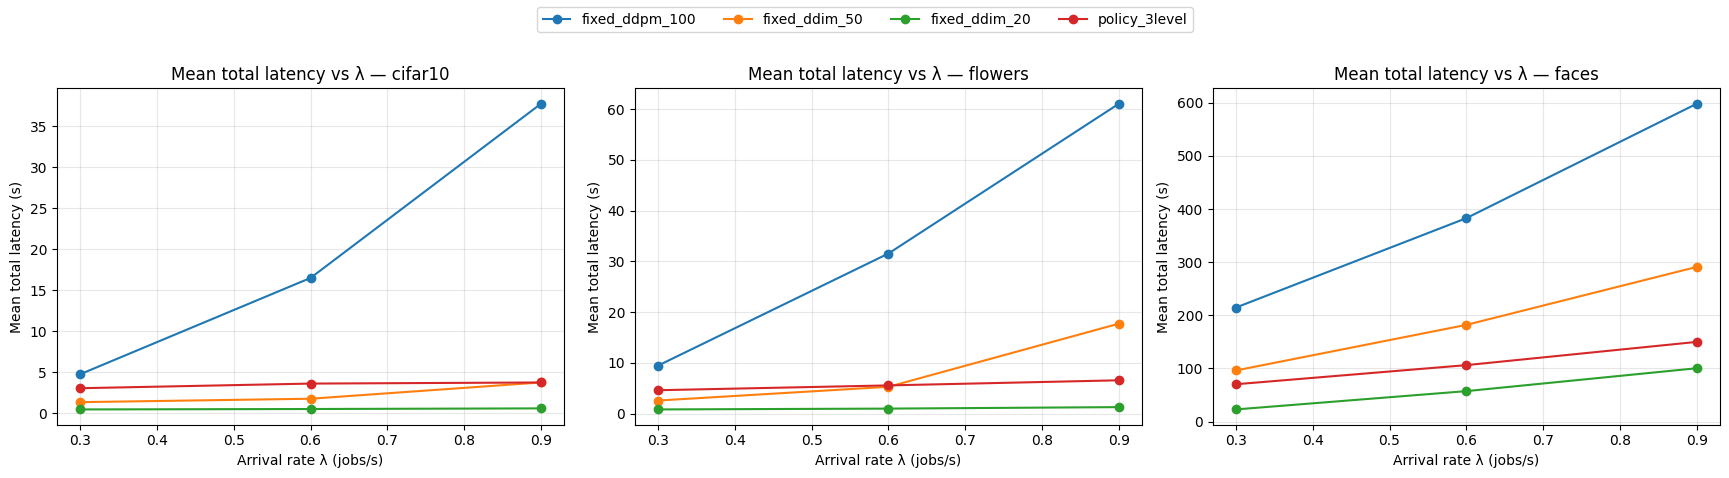

Saved: /content/drive/My Drive/Uni/MSGAI/Project: MSGAI/3_final project/plots/latency_vs_lambda_all_datasets.png


In [87]:
datasets = list(latency_df["dataset"].unique())
policies = list(latency_df["policy"].unique())

fig, axes = plt.subplots(1, len(datasets), figsize=(5.8 * len(datasets), 4.8), sharey=False)

if len(datasets) == 1:
    axes = [axes]

for ax, dataset_key in zip(axes, datasets):
    sub = latency_df[latency_df["dataset"] == dataset_key].copy()

    for policy in policies:
        dfp = sub[sub["policy"] == policy].sort_values("lambda")
        ax.plot(dfp["lambda"], dfp["tot_mean"], marker="o", label=policy)

    ax.set_title(f"Mean total latency vs λ — {dataset_key}")
    ax.set_xlabel("Arrival rate λ (jobs/s)")
    ax.set_ylabel("Mean total latency (s)")
    ax.grid(True, alpha=0.3)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=min(len(labels), 4), frameon=True)
plt.tight_layout(rect=[0, 0, 1, 0.90])

save_path = f"{PROJECT_ROOT}/plots/latency_vs_lambda_all_datasets.png"
plt.savefig(save_path, dpi=150)
plt.show()
print(f"Saved: {save_path}")

---

**Plot 1 - Interpretation**

This figure shows how the mean end-to-end latency grows with the arrival rate $\lambda$ for the three datasets under different policies. Across all datasets, the fixed **DDPM-100** policy exhibits a steep, almost linear increase in latency as $\lambda$ rises, indicating that its long service times quickly push the system toward saturation and cause waiting times to dominate. The fixed **DDIM-50** and **DDIM-20** baselines have much flatter curves, reflecting their shorter service times and better stability under load. The **queue-aware 3-level policy** consistently lies between these extremes: under low load it incurs higher latency than the fastest fixed baseline because it still uses more expensive configurations, but as $\lambda$ increases it adapts and prevents latency from exploding. This effect is especially pronounced for the **faces** dataset, where per-step computation is very expensive: here, adaptation reduces latency by several hundreds of seconds compared to DDPM-100 at high load. Overall, the plot confirms the core hypothesis of the project: adapting computation to load dramatically improves scalability while avoiding the catastrophic queueing behavior of fixed high-quality sampling.


---

**2. Stacked Latency Breakdown (Wait vs Service)**

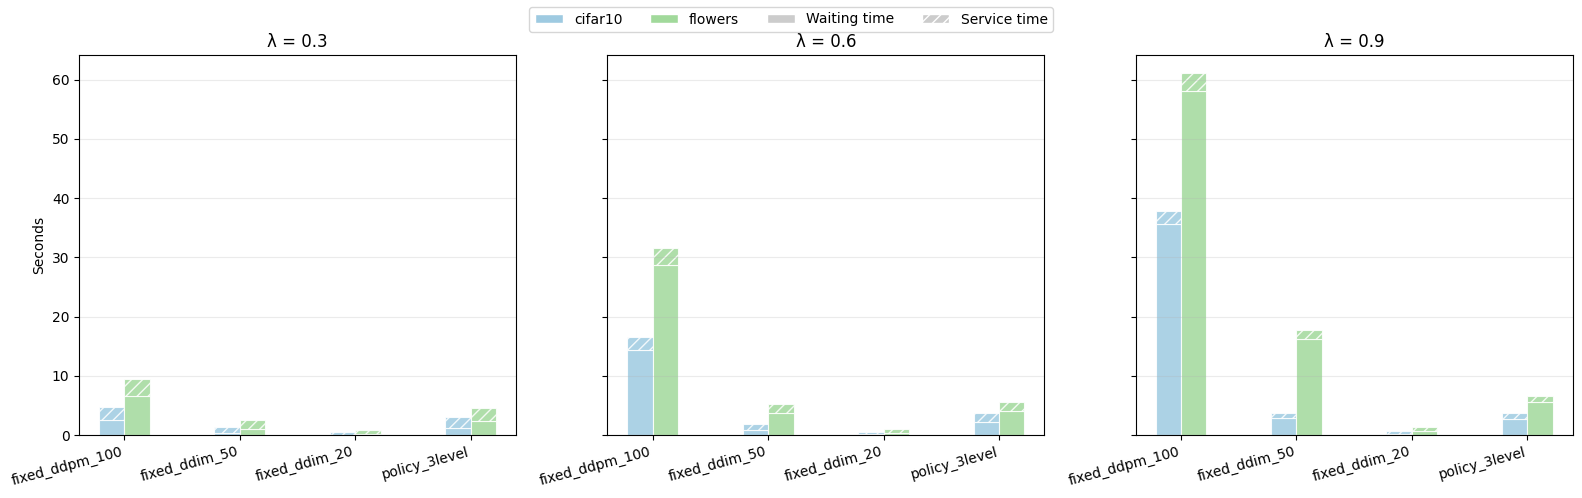

Saved: /content/drive/My Drive/Uni/MSGAI/Project: MSGAI/3_final project/plots/latency_breakdown_cifar10-flowers_all_lambdas.png


In [104]:
datasets = ["cifar10", "flowers"]   # faces omitted for readability
policies = ["fixed_ddpm_100", "fixed_ddim_50", "fixed_ddim_20", "policy_3level"]
lambdas = [0.3, 0.6, 0.9]

dataset_colors = {
    "cifar10": "#9ecae1",  # light blue
    "flowers": "#a1d99b",  # light green
}

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

for ax, lam in zip(axes, lambdas):
    sub = latency_df[latency_df["lambda"] == lam].copy()

    x = np.arange(len(policies))
    width = 0.22

    for i, dset in enumerate(datasets):
        s = sub[sub["dataset"] == dset].set_index("policy").reindex(policies)

        wait = s["wait_mean"].values
        srv  = s["srv_mean"].values

        xpos = x + (i - 0.5) * width

        # Waiting time
        ax.bar(
            xpos, wait, width=width,
            color=dataset_colors[dset], alpha=0.85,
            edgecolor="white", linewidth=0.8
        )

        # Service time (stacked)
        ax.bar(
            xpos, srv, width=width, bottom=wait,
            color=dataset_colors[dset], alpha=0.85,
            edgecolor="white", linewidth=0.8,
            hatch="///"
        )

    ax.set_xticks(x)
    ax.set_xticklabels(policies, rotation=15, ha="right")
    ax.set_title(f"λ = {lam}")
    ax.grid(True, axis="y", alpha=0.25)

axes[0].set_ylabel("Seconds")
fig.suptitle("", y=1.15)

# Legend
dataset_patches = [
    mpatches.Patch(facecolor=dataset_colors[d], edgecolor="white", label=d)
    for d in datasets
]
wait_patch = mpatches.Patch(facecolor="#cccccc", edgecolor="white", label="Waiting time")
srv_patch  = mpatches.Patch(facecolor="#cccccc", edgecolor="white", hatch="///", label="Service time")

fig.legend(
    handles=dataset_patches + [wait_patch, srv_patch],
    loc="upper center",
    ncol=4,
    frameon=True
)

plt.tight_layout()
save_path = f"{PROJECT_ROOT}/plots/latency_breakdown_cifar10-flowers_all_lambdas.png"
plt.savefig(save_path, dpi=150, bbox_inches="tight")
plt.show()

print(f"Saved: {save_path}")

---

**Plot 2 — Interpretation**

The figure above shows the decomposition of total latency into **waiting time** and **service time** for CIFAR-10 and Flowers at three load levels (λ = 0.3, 0.6, 0.9).
We omit the Faces dataset in this visualization because its absolute latency values are orders of magnitude larger, which would compress the other bars and obscure meaningful comparisons.

At **low load (λ = 0.3)**, service time constitutes a substantial fraction of end-to-end latency for all policies, and differences are mainly driven by the chosen sampler. Fixed DDPM incurs the largest service cost, while DDIM-based configurations are noticeably faster. The queue-aware policy sits in between, reflecting its preference for higher-quality configurations when congestion is low.

As load increases to **λ = 0.6 and λ = 0.9**, waiting time rapidly becomes the dominant component for expensive configurations, especially fixed DDPM. This highlights the nonlinear effect of queueing: even modest increases in service time translate into large waiting delays once utilization approaches saturation. In contrast, fixed DDIM-20 maintains very small waiting times across all loads due to its short service time.

The **queue-aware policy** demonstrates the intended behavior: it reduces service time under congestion, which in turn suppresses waiting time growth. Although its service time is higher than the most aggressive fixed baseline, it avoids the queue explosion seen with DDPM while preserving more computation than DDIM-20. This plot clearly illustrates the core mechanism of the project: **small reductions in service time lead to disproportionately large reductions in waiting time**, validating the effectiveness of adaptive early exit under load.

---

**3. Quality–Latency Pareto Frontier**

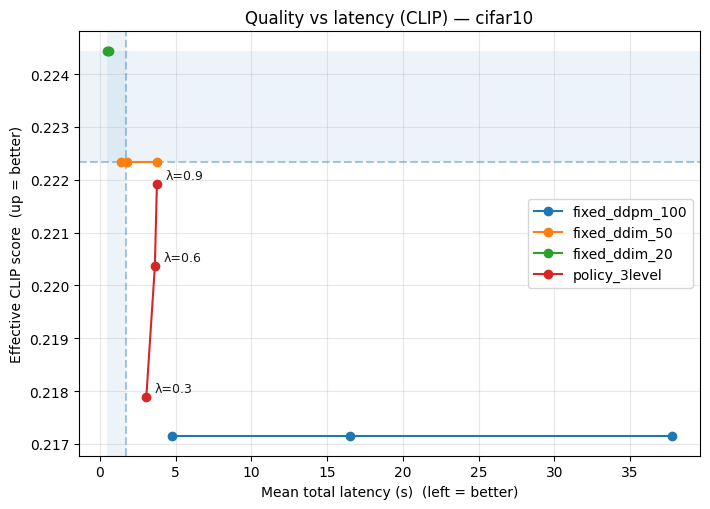

Saved: /content/drive/My Drive/Uni/MSGAI/Project: MSGAI/3_final project/plots/quality_vs_latency_quadrants_cifar10.png


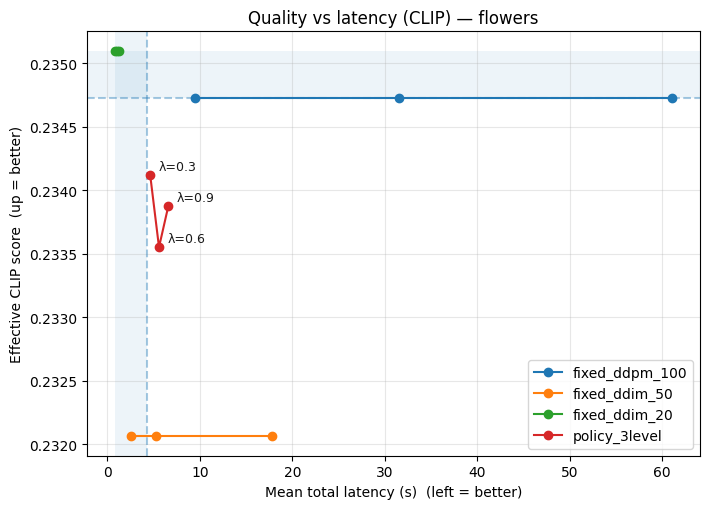

Saved: /content/drive/My Drive/Uni/MSGAI/Project: MSGAI/3_final project/plots/quality_vs_latency_quadrants_flowers.png


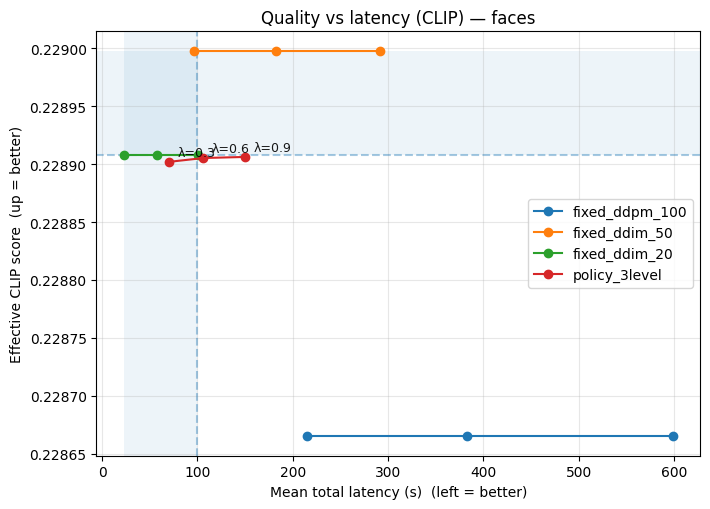

Saved: /content/drive/My Drive/Uni/MSGAI/Project: MSGAI/3_final project/plots/quality_vs_latency_quadrants_faces.png


In [105]:
merged = policy_quality_df.merge(latency_df, on=["dataset", "lambda", "policy"], how="inner")

datasets = list(merged["dataset"].unique())
policies = ["fixed_ddpm_100", "fixed_ddim_50", "fixed_ddim_20", "policy_3level"]

for dataset_key in datasets:
    sub = merged[merged["dataset"] == dataset_key].copy()

    x_thr = np.percentile(sub["tot_mean"], 35)
    y_thr = np.percentile(sub["eff_clip"], 65)

    plt.figure(figsize=(7.2, 5.2))

    plt.axvspan(sub["tot_mean"].min(), x_thr, alpha=0.08)
    plt.axhspan(y_thr, sub["eff_clip"].max(), alpha=0.08)
    plt.axvline(x_thr, linestyle="--", alpha=0.4)
    plt.axhline(y_thr, linestyle="--", alpha=0.4)

    # Track placed annotation positions
    used_positions = []

    def is_too_close(x, y, used, x_tol=0.04, y_tol=0.0004):
        for ux, uy in used:
            if abs(x - ux) < x_tol and abs(y - uy) < y_tol:
                return True
        return False

    for policy in policies:
        dfp = sub[sub["policy"] == policy].sort_values("lambda")
        if dfp.empty:
            continue

        plt.plot(dfp["tot_mean"], dfp["eff_clip"], marker="o", label=policy)

        if policy == "policy_3level":
            for _, r in dfp.iterrows():
                x, y = r["tot_mean"], r["eff_clip"]

                if is_too_close(x, y, used_positions):
                    continue  # skip overlapping labels

                plt.annotate(
                    f"λ={r['lambda']:.1f}",
                    (x, y),
                    textcoords="offset points",
                    xytext=(6, 4),
                    fontsize=9,
                    alpha=0.9
                )
                used_positions.append((x, y))

    plt.title(f"Quality vs latency (CLIP) — {dataset_key}")
    plt.xlabel("Mean total latency (s)  (left = better)")
    plt.ylabel("Effective CLIP score  (up = better)")
    plt.grid(True, alpha=0.3)
    plt.legend(frameon=True)

    plt.tight_layout()
    save_path = f"{PROJECT_ROOT}/plots/quality_vs_latency_quadrants_{dataset_key}.png"
    plt.savefig(save_path, dpi=150)
    plt.show()

    print(f"Saved: {save_path}")


**Plot 3 — Interpretation**

This figure visualizes the **quality–latency trade-off** for each dataset by plotting, for every policy and arrival rate $\lambda$:

* **x-axis:** mean total latency (left is better),
* **y-axis:** effective CLIP score (up is better).

Each point corresponds to a specific $\lambda \in \{0.3, 0.6, 0.9\}$, annotated next to the marker. Fixed policies appear as nearly horizontal lines because their quality is independent of load, while the **queue-aware policy traces a vertical trajectory** as load increases, reflecting its adaptive behavior.

To guide interpretation, the plot is divided into regions using dashed threshold lines:

* The **vertical dashed line** marks a “reasonably low latency” region.
* The **horizontal dashed line** marks a “reasonably high quality” region.
* The **top-left shaded quadrant** therefore represents the **desirable operating region**: low latency *and* high quality.

<br>

**CIFAR-10.**
For CIFAR-10, `fixed_ddpm_100` consistently achieves the lowest CLIP score while suffering extremely high latency as $\lambda$ increases, placing it firmly in the bottom-right (worst) region.
`fixed_ddim_20` achieves the highest CLIP score and lowest latency, but this comes from aggressively truncating computation, which may not always be acceptable.

The **queue-aware `policy_3level` moves upward and leftward as $\lambda$ increases**: under low load it behaves closer to DDPM, while under higher load it shifts toward DDIM-based configurations. As a result, it remains near the desirable region even at high arrival rates, achieving **substantial latency reductions with only a small quality drop** relative to the best fixed baseline.

**Flowers.**
For Flowers, quality differences across configurations are smaller, but latency differences are dramatic. `fixed_ddpm_100` remains high-quality but becomes prohibitively slow as load increases. `fixed_ddim_50` trades away noticeable quality for speed, while `fixed_ddim_20` is fastest but not consistently best in CLIP.

The queue-aware policy again **tracks a middle path**: it significantly reduces latency compared to DDPM while maintaining CLIP scores closer to the high-quality region than fixed DDIM. Its points cluster near the upper-left quadrant, illustrating a controlled and adaptive quality–latency compromise.

**Faces.**
For Faces, CLIP scores are nearly identical across all policies, indicating that this metric is relatively insensitive for this dataset at the evaluated resolution. In this regime, latency becomes the dominant concern. Here, the adaptive policy provides **large latency reductions** compared to DDPM, while maintaining essentially the same measured quality. This places `policy_3level` clearly to the left of DDPM and closer to the optimal region.

<br>

**Key Takeaways.**
Across all datasets, this plot highlights three important patterns:

1. **Fixed high-quality policies collapse under load**, moving far right as waiting time dominates.
2. **Fixed low-compute policies are fast but inflexible**, always sacrificing quality regardless of system state.
3. **The queue-aware policy adapts with load**, tracing a favorable path that keeps it near the low-latency, high-quality region even as $\lambda$ increases.

Overall, this figure provides a compact, intuitive visualization of the project’s core result: **queue-aware early exit enables significantly better operating points than any single fixed configuration**, especially under moderate to high load.


---

## 10. Ablations & Sensitivity Analysis

Section 9 evaluated our **default** policies end-to-end.
This section asks the next question: *which parts of the early-exit mechanism actually matter, and how stable is it if we change them?*

Early-exit diffusion policies have three main “knobs”:

* **Queue thresholds** $(T_1, T_2)$: *when* we switch to cheaper computation
* **Step budgets** $(k_\text{full}, k_\text{med}, k_\text{short})$: *how much* cheaper each tier is
* **Sampler switching**: whether we truly need **DDPM → DDIM** under load

For each ablation, we run the same simulation setup:

* Datasets: **all** keys in `DATASETS_INFO`
* Arrival rates: $\lambda \in {0.3, 0.6, 0.9}$
* Horizon: $H = 60$ seconds
* Service time model: $$S(n) \approx \alpha + \beta n$$ from Section 6

To connect latency and quality, we reuse the precomputed *offline* quality grids from Section 9:

* `quality_grid_<dataset>.csv` containing $(\text{algo}, n)\mapsto(\text{CLIP}, \text{FID})$

and approximate the **effective quality** of a policy run by averaging the quality values of the configurations actually used by the jobs.

The outputs of this section are:

* `ablation_thresholds.csv`
* `ablation_steps.csv`
* `ablation_switch.csv`
  plus a compact set of plots (Pareto, sensitivity heatmaps, robustness curves) saved into `plots/`.


### 10.1 Helper: quality lookup and effective policy quality

To plot *latency vs quality* for ablations, we need to map each simulated job’s choice $(\text{algo}, n)$ to an estimated quality value.

We load the per-dataset quality grids from Section 9 and build a lookup:

$$
(\text{algo}, n)\ \mapsto\ (\text{CLIP}, \text{FID}).
$$

Given a list of simulated jobs, we approximate policy-level quality by averaging the grid values across the jobs:

* effective CLIP $= \frac{1}{N}\sum_{i=1}^{N}\text{CLIP}(\text{algo}_i, n_i)$
* effective FID  $= \frac{1}{N}\sum_{i=1}^{N}\text{FID}(\text{algo}_i, n_i)$

This matches the same approximation used in Section 9’s `policy_quality_summary.csv`, but now we apply it directly inside ablation plotting.

In [150]:
# Section 9 fixed configs (baseline)
BASE_QUALITY_CONFIGS = [("ddpm", 100), ("ddim", 50), ("ddim", 20)]

# Section 10 Ablation 2 step configs
STEP_CONFIGS = {"conservative": (100, 50, 20), "aggressive":   (80, 40, 10), "quality_bias": (150, 80, 40)}

# Section 10 Ablation 3 (switching) uses tiers (100,50,20) but both algos
SWITCHING_STEPS = [100, 50, 20]
ABLATION1_STEPS = [100, 50, 20]

def collect_required_quality_configs() -> List[Tuple[str, int]]:
    """Return a sorted list of all (algo, steps) pairs we need quality for."""
    req = set(BASE_QUALITY_CONFIGS)

    # Ablation 2: mixed tiers with DDPM full + DDIM reduced
    all_steps = set()
    for _, (kf, km, ks) in STEP_CONFIGS.items():
        all_steps.update([kf, km, ks])
    all_steps.update(SWITCHING_STEPS)
    all_steps.update(ABLATION1_STEPS)

    for s in all_steps:
        req.add(("ddpm", int(s)))
        req.add(("ddim", int(s)))

    return sorted(req, key=lambda x: (x[0], x[1]))

REQUIRED_QUALITY_CONFIGS = collect_required_quality_configs()
print("Required quality configs:", REQUIRED_QUALITY_CONFIGS)

Required quality configs: [('ddim', 10), ('ddim', 20), ('ddim', 40), ('ddim', 50), ('ddim', 80), ('ddim', 100), ('ddim', 150), ('ddpm', 10), ('ddpm', 20), ('ddpm', 40), ('ddpm', 50), ('ddpm', 80), ('ddpm', 100), ('ddpm', 150)]


**Rewrite `build_quality_grid`to extend for ablations & sensitivity analysis**

In [151]:
def build_or_extend_quality_grid(dataset_key: str, required_configs: List[Tuple[str, int]], project_root: str, device=None, n_real: int = 512, n_fake: int = 512, fake_batch: int = 32, clip_batch: int = 32, fid_batch: int = 32, seed: int = 42, verbose: bool = True) -> pd.DataFrame:
    """
    Ensure quality_grid_<dataset>.csv contains ALL required (algo,steps).
    Only computes missing entries, appends to CSV, returns full DataFrame.
    """
    os.makedirs(f"{project_root}/logs", exist_ok=True)
    csv_path = f"{project_root}/logs/quality_grid_{dataset_key}.csv"

    # Load existing grid if present
    if os.path.exists(csv_path):
        df_existing = pd.read_csv(csv_path)
        existing = set((row["algo"].lower(), int(row["steps"])) for _, row in df_existing.iterrows())
    else:
        df_existing = pd.DataFrame(columns=["dataset","algo","steps","n_real","n_fake","clip_mean","clip_std","fid"])
        existing = set()

    missing = [cfg for cfg in required_configs if (cfg[0].lower(), int(cfg[1])) not in existing]

    if verbose:
        print(f"\n=== Quality grid check: {dataset_key} ===")
        print(f"Existing entries: {len(existing)} | Required: {len(required_configs)} | Missing: {len(missing)}")

    if len(missing) == 0:
        return df_existing

    # Compute missing configs using your existing helper
    df_new = build_quality_grid(dataset_key=dataset_key, quality_configs=missing, n_real=n_real, n_fake=n_fake, fake_batch=fake_batch, clip_batch=clip_batch, fid_batch=fid_batch, seed=seed, device=device, project_root=project_root, save_csv=False, verbose=verbose)

    # Append and save
    df_full = pd.concat([df_existing, df_new], ignore_index=True)

    # De-duplicate just in case
    df_full = df_full.drop_duplicates(subset=["dataset","algo","steps"], keep="last").sort_values(["algo","steps"])

    df_full.to_csv(csv_path, index=False)
    if verbose:
        print(f"Saved extended quality grid → {csv_path}")

    return df_full

In [152]:
for dataset_key in DATASETS_INFO.keys():
    torch.cuda.empty_cache()
    _ = build_or_extend_quality_grid(dataset_key=dataset_key, required_configs=REQUIRED_QUALITY_CONFIGS, project_root=PROJECT_ROOT, device=device, seed=SEED, verbose=True)


=== Quality grid check: cifar10 ===
Existing entries: 14 | Required: 14 | Missing: 0

=== Quality grid check: flowers ===
Existing entries: 14 | Required: 14 | Missing: 0

=== Quality grid check: faces ===
Existing entries: 14 | Required: 14 | Missing: 0


In [155]:
def load_quality_lookup(project_root: str) -> Dict[str, Dict[Tuple[str,int], Dict[str,float]]]:
    """
    QUALITY_LOOKUP[dataset][(algo, steps)] = {"clip_mean": ..., "fid": ...}
    """
    lookup = {}
    for dataset_key in DATASETS_INFO.keys():
        path = f"{project_root}/logs/quality_grid_{dataset_key}.csv"
        df = pd.read_csv(path)
        table = {}
        for _, row in df.iterrows():
            key = (str(row["algo"]).lower(), int(row["steps"]))
            table[key] = {"clip_mean": float(row["clip_mean"]), "fid": float(row["fid"])}
        lookup[dataset_key] = table
    return lookup

QUALITY_LOOKUP = load_quality_lookup(PROJECT_ROOT)

def approximate_policy_quality(dataset_key: str, jobs: List[JobRecord]) -> Tuple[float, float]:
    """
    Now complete: no skipped jobs as long as grid was extended properly.
    """
    table = QUALITY_LOOKUP[dataset_key]
    clips, fids = [], []
    for r in jobs:
        key = (r.algo.lower(), int(r.steps))
        q = table[key]
        clips.append(q["clip_mean"])
        fids.append(q["fid"])
    return float(np.mean(clips)), float(np.mean(fids))

In [156]:
def style_ax(ax):
    ax.grid(True, alpha=0.25)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

def savefig(path: str):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    plt.tight_layout()
    plt.savefig(path, dpi=160, bbox_inches="tight")
    plt.close()

def pareto_frontier(points: List[Tuple[float,float]]) -> List[int]:
    """
    Return indices of Pareto-optimal points for:
      minimize latency (x), maximize quality (y)
    """
    idxs = []
    for i,(x,y) in enumerate(points):
        dominated = False
        for j,(x2,y2) in enumerate(points):
            if j == i:
                continue
            if (x2 <= x and y2 >= y) and (x2 < x or y2 > y):
                dominated = True
                break
        if not dominated:
            idxs.append(i)
    return idxs

### 10.2 Ablation 1 — Sensitivity to queue thresholds $(T_1, T_2)$

The thresholds determine *when* the mechanism switches away from full DDPM:

* If $T_1$ is too small → switch to DDIM too early → quality loss even at low load
* If $T_1$ and $T_2$ are too large → react too late → queues build up and latency explodes

We evaluate:

* $T_1 \in {1,2,4}$
* $T_2 \in {3,5,8}$ with $T_2 > T_1$

with fixed step budgets:

* $k_\text{full}=100$, $k_\text{med}=50$, $k_\text{short}=20$

**10.2.1 Simulation**

In [157]:
def policy_threshold_variant(T1, T2, k_full=100, k_med=50, k_short=20):
    def _policy(qlen):
        if qlen >= T2:
            return ("ddim", k_short)
        elif qlen >= T1:
            return ("ddim", k_med)
        else:
            return ("ddpm", k_full)
    _policy.__name__ = f"policy_T1{T1}_T2{T2}"
    return _policy


threshold_results = []

T1_values = [1, 2, 4]
T2_values = [3, 5, 8]
HORIZON = 60.0
LAMBDAS = [0.3, 0.6, 0.9]

for dataset_key in DATASETS_INFO.keys():
    fits = FITS_ALL[dataset_key]  # DDPM/DDIM service times for this dataset

    for T1, T2 in itertools.product(T1_values, T2_values):
        if T2 <= T1:
            continue  # only valid ordering

        policy_fn = policy_threshold_variant(T1, T2)

        for lam in LAMBDAS:
            results = simulate_queue(lambda_rate=lam, horizon_s=HORIZON, policy_fn=policy_fn, fits=fits)
            stats = summarize_jobs(results)

            threshold_results.append({"dataset": dataset_key, "lambda": lam, "policy": policy_fn.__name__, "T1": T1, "T2": T2, **stats})

df_thresh = pd.DataFrame(threshold_results)
df_thresh.to_csv(f"{PROJECT_ROOT}/logs/ablation_thresholds.csv", index=False)
df_thresh.head()

,dataset,lambda,policy,T1,T2,n,wait_mean,srv_mean,tot_mean,wait_p95,tot_p95
0,cifar10,0.3,policy_T11_T23,1,3,25,0.831022,1.454464,2.285486,2.110973,3.037225
1,cifar10,0.6,policy_T11_T23,1,3,39,1.224867,1.196981,2.421848,3.018094,3.521383
2,cifar10,0.9,policy_T11_T23,1,3,62,1.796065,0.887778,2.683843,3.450486,3.868733
3,cifar10,0.3,policy_T11_T25,1,5,25,0.898001,1.499116,2.397116,2.110973,3.087371
4,cifar10,0.6,policy_T11_T25,1,5,39,1.563706,1.223766,2.787472,3.640456,4.561039


**10.2.2 Plots for Ablation 1**

We add three complementary views:

1. **Latency–quality Pareto** at a representative load $\lambda=0.6$
2. **Sensitivity heatmap** of mean total latency over $(T_1,T_2)$
3. **Robustness curves** across $\lambda$ for the best vs worst thresholds (chosen at $\lambda=0.6$)

In [158]:
REP_LAMBDA = 0.6  # representative medium load
datasets = list(DATASETS_INFO.keys())

# 1) Pareto at λ=0.6  (ONE figure, 3 subplots = datasets)
fig, axes = plt.subplots(1, len(datasets), figsize=(18, 4.6), sharey=False)
if len(datasets) == 1:
    axes = [axes]

for ax, dataset_key in zip(axes, datasets):
    fits = FITS_ALL[dataset_key]
    rows = []

    for T1, T2 in itertools.product(T1_values, T2_values):
        if T2 <= T1:
            continue
        policy_fn = policy_threshold_variant(T1, T2)
        jobs = simulate_queue(REP_LAMBDA, HORIZON, policy_fn, fits=fits)
        stats = summarize_jobs(jobs)
        eff_clip, eff_fid = approximate_policy_quality(dataset_key, jobs)
        rows.append({"T1": T1, "T2": T2, "tot_mean": stats["tot_mean"], "eff_clip": eff_clip, "eff_fid": eff_fid})

    dfp = pd.DataFrame(rows).sort_values("tot_mean")

    ax.scatter(dfp["tot_mean"], dfp["eff_clip"], alpha=0.9)

    # annotate lightly (only best few)
    for _, r in dfp.head(6).iterrows():
        ax.annotate(f"T1={r['T1']},T2={r['T2']}", (r["tot_mean"], r["eff_clip"]), fontsize=8)

    # pareto highlight
    pts = list(zip(dfp["tot_mean"].tolist(), dfp["eff_clip"].tolist()))
    pf = pareto_frontier(pts)
    ax.scatter(dfp.iloc[pf]["tot_mean"], dfp.iloc[pf]["eff_clip"], s=90, marker="*", label="Pareto-optimal")

    ax.set_title(dataset_key)
    ax.set_xlabel("Mean total latency (s) ↓")
    ax.set_ylabel("Effective CLIP ↑")
    style_ax(ax)
    ax.legend()

fig.suptitle(f"Ablation 1: Threshold Pareto (λ={REP_LAMBDA})", y=1.02)
plt.tight_layout()
path = f"{PROJECT_ROOT}/plots/ablation1_pareto_all_datasets.png"
savefig(path)
plt.show()

# 2) Latency heatmap at λ=0.6
df_thresh = pd.read_csv(f"{PROJECT_ROOT}/logs/ablation_thresholds.csv")

fig, axes = plt.subplots(1, len(datasets), figsize=(18, 4.6), sharey=False)
if len(datasets) == 1:
    axes = [axes]

ims = []
for ax, dataset_key in zip(axes, datasets):
    sub = df_thresh[(df_thresh["dataset"] == dataset_key) & (df_thresh["lambda"] == REP_LAMBDA)]
    pivot = sub.pivot_table(index="T2", columns="T1", values="tot_mean", aggfunc="mean")

    im = ax.imshow(pivot.values, aspect="auto")
    ims.append(im)

    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns)
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    ax.set_xlabel("T1")
    ax.set_ylabel("T2")
    ax.set_title(dataset_key)
    style_ax(ax)

fig.subplots_adjust(top=1.05)

# add a new axis for the colorbar (top-right, horizontal)
cbar_ax = fig.add_axes([0.25, 1.05, 0.4, 0.035])

cbar = fig.colorbar(ims[0], cax=cbar_ax, orientation="horizontal")
cbar.set_label("Mean total latency (s)")

fig.suptitle(f"Ablation 1: Latency Heatmap (λ={REP_LAMBDA})", y=1.20)

plt.tight_layout(rect=[0, 0, 1, 0.82])
path = f"{PROJECT_ROOT}/plots/ablation1_heatmap_all_datasets.png"
savefig(path)
plt.show()

# 3) Robustness curves best vs worst
fig, axes = plt.subplots(1, len(datasets), figsize=(18, 4.6), sharey=False)
if len(datasets) == 1:
    axes = [axes]

for ax, dataset_key in zip(axes, datasets):
    sub = df_thresh[df_thresh["dataset"] == dataset_key]

    rep = (
        sub[sub["lambda"] == REP_LAMBDA]
        .groupby(["T1", "T2"])["tot_mean"]
        .mean()
        .reset_index()
    )
    best = rep.loc[rep["tot_mean"].idxmin()]
    worst = rep.loc[rep["tot_mean"].idxmax()]

    df_best = sub[(sub["T1"] == best["T1"]) & (sub["T2"] == best["T2"])].sort_values("lambda")
    df_worst = sub[(sub["T1"] == worst["T1"]) & (sub["T2"] == worst["T2"])].sort_values("lambda")

    ax.plot(df_best["lambda"], df_best["tot_mean"], marker="o",
            label=f"Best T1={int(best['T1'])},T2={int(best['T2'])}")
    ax.plot(df_worst["lambda"], df_worst["tot_mean"], marker="o",
            label=f"Worst T1={int(worst['T1'])},T2={int(worst['T2'])}")

    ax.set_title(dataset_key)
    ax.set_xlabel("Arrival rate λ (jobs/s)")
    ax.set_ylabel("Mean total latency (s)")
    style_ax(ax)
    ax.legend()

fig.suptitle("Ablation 1: Robustness (best vs worst thresholds)", y=1.02)
plt.tight_layout()
path = f"{PROJECT_ROOT}/plots/ablation1_robustness_all_datasets.png"
savefig(path)
plt.show()


/tmp/ipython-input-2062506595.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.82])
/tmp/ipython-input-722853338.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


---

**Interpretation**

**CSV: `ablation_thresholds.csv`.**

This table reports queueing statistics for all valid $(T_1, T_2)$ threshold combinations across datasets and arrival rates. The key pattern is that **threshold choice strongly controls waiting time growth**: small thresholds $(T_1=1)$ reduce queue buildup but switch to DDIM earlier, while large thresholds $(T_1=4, T_2=8)$ delay switching and cause **explosive waiting times under moderate and high load**. Across all datasets, service time remains relatively stable, confirming that **latency inflation is dominated by waiting**, not computation. This validates the queue-aware design goal: threshold tuning directly determines system stability under load.

**Plot 1: Threshold Pareto (Latency vs Quality at $\lambda=0.6)$.**

The Pareto plots show a clear **latency–quality trade-off frontier**. Aggressive thresholds achieve low latency but slightly reduced CLIP, while conservative thresholds preserve quality at the cost of high latency. Importantly, only a small subset of $(T_1, T_2)$ pairs are Pareto-optimal, indicating that **most threshold choices are strictly suboptimal**. The selected operating point $(T_1=1, T_2=3)$ lies near the Pareto knee for all datasets, offering strong latency reductions with minimal quality loss—exactly the intended behavior of the early-exit policy.

**Plot 2: Latency Heatmap over $(T_1, T_2)$.**

The heatmaps visualize sensitivity to threshold placement. Latency increases monotonically as thresholds grow, with especially steep degradation when both $T_1$ and $T_2$ are large. This effect is consistent across datasets but amplified for heavier workloads (e.g., faces). The heatmap confirms that **late switching is dangerous**: once queues form, even small increases in service time lead to nonlinear waiting amplification. This reinforces that early congestion detection is critical for scalable diffusion serving.

**Plot 3: Robustness Curves (Best vs Worst Thresholds).**

Robustness curves show how the best and worst threshold choices behave as load increases. The best configuration remains stable across $\lambda$, with near-linear latency growth, while the worst configuration exhibits **superlinear blow-up**, even at moderate arrival rates. This gap widens dramatically for more expensive datasets, demonstrating that **threshold tuning becomes more critical as model cost increases**. The early-exit mechanism is therefore not just an optimization, but a necessity for robustness under realistic load variation.

**Summary.**

Ablation 1 shows that queue thresholds are a **first-order control knob** for performance. Properly chosen thresholds prevent queue collapse, preserve quality, and ensure robustness across datasets and loads. Poor threshold choices negate the benefits of early exit entirely. Overall, this ablation validates the central premise of the project: **small, interpretable scheduling decisions can yield large system-level gains in generative AI serving**.


---

### 10.3 Ablation 2 — Sensitivity to step budgets $(k_\text{full}, k_\text{med}, k_\text{short})$

Here we keep thresholds fixed (same as the default 3-level policy) and vary the step budgets to test how strongly compute scaling affects latency and quality.

We test:

* **conservative**: $(100,50,20)$ (default)
* **aggressive**: $(80,40,10)$ (faster, riskier)
* **quality_bias**: $(150,80,40)$ (higher quality, higher service time)

**10.3.1 Simulation**

In [159]:
step_configs = {"conservative": (100, 50, 20), "aggressive": (80, 40, 10), "quality_bias": (150, 80, 40)}

step_results = []

for dataset_key in DATASETS_INFO.keys():
    fits = FITS_ALL[dataset_key]

    for config_name, (k_full, k_med, k_short) in step_configs.items():
        def policy_fn(qlen, kf=k_full, km=k_med, ks=k_short):
            if qlen >= 5:
                return ("ddim", ks)
            elif qlen >= 2:
                return ("ddim", km)
            else:
                return ("ddpm", kf)

        policy_fn.__name__ = f"policy_{config_name}"

        for lam in LAMBDAS:
            results = simulate_queue(lambda_rate=lam, horizon_s=HORIZON, policy_fn=policy_fn, fits=fits)
            stats = summarize_jobs(results)
            step_results.append({"dataset": dataset_key, "lambda": lam, "policy": config_name, "k_full": k_full, "k_med": k_med, "k_short": k_short, **stats})

df_steps = pd.DataFrame(step_results)
df_steps.to_csv(f"{PROJECT_ROOT}/logs/ablation_steps.csv", index=False)
df_steps.head()

,dataset,lambda,policy,k_full,k_med,k_short,n,wait_mean,srv_mean,tot_mean,wait_p95,tot_p95
0,cifar10,0.3,conservative,100,50,20,25,1.365484,1.736715,3.102199,3.217147,4.275367
1,cifar10,0.6,conservative,100,50,20,39,2.290882,1.438834,3.729716,4.828451,5.749034
2,cifar10,0.9,conservative,100,50,20,62,3.181349,0.980115,4.161464,5.705681,6.128536
3,cifar10,0.3,aggressive,80,40,10,25,0.973969,1.453445,2.427414,2.750087,3.609320
4,cifar10,0.6,aggressive,80,40,10,39,1.398153,1.290548,2.688701,3.499258,4.010846


**10.3.2 Plots for Ablation 2**

1. **Latency–quality Pareto** at $\lambda=0.6$
2. **Sensitivity heatmap** over $(\lambda,\ \text{config})$
3. **Robustness curves**: total latency vs $\lambda$ per config

In [165]:
REP_LAMBDA = 0.6  # representative medium load
datasets = list(DATASETS_INFO.keys())

df_steps = pd.read_csv(f"{PROJECT_ROOT}/logs/ablation_steps.csv")

# 1) Pareto at λ=0.6  (ONE figure, 3 subplots = datasets)
fig, axes = plt.subplots(1, len(datasets), figsize=(18, 4.6), sharey=False)
if len(datasets) == 1:
    axes = [axes]

for ax, dataset_key in zip(axes, datasets):
    fits = FITS_ALL[dataset_key]
    rows = []

    for config_name, (k_full, k_med, k_short) in STEP_CONFIGS.items():
        def policy_fn(qlen, kf=k_full, km=k_med, ks=k_short):
            if qlen >= 5: return ("ddim", ks)
            if qlen >= 2: return ("ddim", km)
            return ("ddpm", kf)

        jobs = simulate_queue(REP_LAMBDA, HORIZON, policy_fn, fits=fits)
        stats = summarize_jobs(jobs)
        eff_clip, eff_fid = approximate_policy_quality(dataset_key, jobs)
        rows.append({"config": config_name, "tot_mean": stats["tot_mean"], "eff_clip": eff_clip})

    dfp = pd.DataFrame(rows).sort_values("tot_mean")

    for _, r in dfp.iterrows():
        ax.scatter(r["tot_mean"], r["eff_clip"], alpha=0.9)
        ax.annotate(r["config"], (r["tot_mean"], r["eff_clip"]),
                    fontsize=9, xytext=(6, 4), textcoords="offset points")

    ax.set_title(dataset_key)
    ax.set_xlabel("Mean total latency (s) ↓")
    ax.set_ylabel("Effective CLIP ↑")
    style_ax(ax)

fig.suptitle(f"Ablation 2: Step Budget Pareto (λ={REP_LAMBDA})", y=1.02)
plt.tight_layout()
path = f"{PROJECT_ROOT}/plots/ablation2_pareto_all_datasets.png"
savefig(path)
plt.show()


# 2) Heatmap over (λ, config) for latency  (ONE figure, 3 subplots = datasets)
fig, axes = plt.subplots(1, len(datasets), figsize=(18, 4.6), sharey=False)
if len(datasets) == 1:
    axes = [axes]

ims = []
for ax, dataset_key in zip(axes, datasets):
    sub = df_steps[df_steps["dataset"] == dataset_key]
    pivot = (
        sub.pivot_table(index="lambda", columns="policy", values="tot_mean", aggfunc="mean")
        .sort_index()
    )

    im = ax.imshow(pivot.values, aspect="auto")
    ims.append(im)

    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns, rotation=20, ha="right")
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    ax.set_xlabel("Step configuration")
    ax.set_ylabel("Arrival rate λ")
    ax.set_title(dataset_key)
    style_ax(ax)

fig.subplots_adjust(top=1.05)

# shared colorbar (top, horizontal)
cbar_ax = fig.add_axes([0.25, 1.05, 0.4, 0.035])
cbar = fig.colorbar(ims[0], cax=cbar_ax, orientation="horizontal")
cbar.set_label("Mean total latency (s)")

fig.suptitle("Ablation 2: Latency Sensitivity (heatmap)", y=1.20)
plt.tight_layout(rect=[0, 0, 1, 0.82])
path = f"{PROJECT_ROOT}/plots/ablation2_heatmap_all_datasets.png"
savefig(path)
plt.show()


# 3) Robustness curves (ONE figure, 3 subplots = datasets)
fig, axes = plt.subplots(1, len(datasets), figsize=(18, 4.6), sharey=False)
if len(datasets) == 1:
    axes = [axes]

for ax, dataset_key in zip(axes, datasets):
    sub = df_steps[df_steps["dataset"] == dataset_key]

    for config in STEP_CONFIGS.keys():
        s2 = sub[sub["policy"] == config].sort_values("lambda")
        ax.plot(s2["lambda"], s2["tot_mean"], marker="o", label=config)

    ax.set_title(dataset_key)
    ax.set_xlabel("Arrival rate λ (jobs/s)")
    ax.set_ylabel("Mean total latency (s)")
    style_ax(ax)
    ax.legend()

fig.suptitle("Ablation 2: Robustness (step budget variants)", y=1.02)
plt.tight_layout()
path = f"{PROJECT_ROOT}/plots/ablation2_robustness_all_datasets.png"
savefig(path)

/tmp/ipython-input-4246461679.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.82])
/tmp/ipython-input-722853338.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


---

**Interpretation**

**CSV: `ablation_steps.csv`.**

This table reports queueing statistics for different **step-budget configurations** under varying arrival rates $\lambda$. Across all datasets, reducing step counts (the *aggressive* setting) consistently lowers service time and therefore total latency, especially as $\lambda$ increases. Conversely, increasing step budgets (*quality_bias*) significantly raises service time, which amplifies waiting time under load and leads to rapidly growing tail latencies. The conservative configuration sits between these extremes, confirming that step budgets directly control the latency–quality operating point of the system.

**Latency Sensitivity Heatmap (over $\lambda$ and step configuration).**

The heatmaps show a clear and monotonic pattern: for any dataset, latency increases both with higher $\lambda$ and with larger step budgets. The aggressive configuration remains stable even at high load, while the quality-biased configuration becomes increasingly costly as $\lambda$ grows. This visualization highlights that **compute-heavy step budgets are not robust to load**, especially for larger models such as *faces*, where absolute latency differences are amplified.

**Latency–Quality Pareto at $\lambda = 0.6$.**

The Pareto plots illustrate the fundamental trade-off induced by step budgets. Aggressive configurations achieve the lowest latency but at the cost of reduced CLIP scores, while quality-biased settings achieve the highest quality with substantially higher latency. The conservative configuration often lies near the “knee” of the curve, offering a balanced compromise. This confirms that **step budgets alone can span a wide Pareto frontier**, even with fixed queue thresholds.

**Robustness Curves (latency vs $\lambda$ per configuration).**

These curves show how each step-budget choice scales with increasing load. Aggressive policies scale the best, exhibiting near-linear growth in latency. Conservative policies grow moderately, while quality-biased policies show steep, sometimes superlinear increases as waiting time dominates. This demonstrates that **step-budget selection critically affects system robustness**, and that high-quality configurations are only viable at low load.

**Overall takeaway.**

Ablation 2 shows that step budgets are a powerful but blunt control knob: they directly trade quality for latency and strongly influence system stability under load. While aggressive budgets ensure responsiveness, they sacrifice quality even when the system is lightly loaded. Quality-biased budgets achieve strong fidelity but are brittle under congestion. This motivates the need for **adaptive policies** (as studied in the main experiments) that dynamically adjust step budgets based on queue state, rather than fixing them globally.

---

### 10.4 Ablation 3 — Effect of sampler switching (DDPM → DDIM)

The mechanism assumes **switching** matters:

* DDPM is used when lightly loaded (quality)
* DDIM is used under load (speed)

This ablation checks whether switching is actually beneficial compared to “pure” strategies.

We compare:

* **ddpm_only**: all tiers use DDPM
* **ddim_only**: all tiers use DDIM
* **mixed**: DDPM at full tier, DDIM otherwise (our mechanism)

**10.4.1 Simulation**

In [161]:
def policy_ddpm_only(qlen):
    if qlen >= 5: return ("ddpm", 20)
    if qlen >= 2: return ("ddpm", 50)
    return ("ddpm", 100)

def policy_ddim_only(qlen):
    if qlen >= 5: return ("ddim", 20)
    if qlen >= 2: return ("ddim", 50)
    return ("ddim", 100)

def policy_mixed(qlen):
    if qlen >= 5: return ("ddim", 20)
    if qlen >= 2: return ("ddim", 50)
    return ("ddpm", 100)

switch_policies = {"ddpm_only": policy_ddpm_only, "ddim_only": policy_ddim_only, "mixed": policy_mixed}

switch_results = []

for dataset_key in DATASETS_INFO.keys():
    fits = FITS_ALL[dataset_key]

    for policy_name, policy_fn in switch_policies.items():
        for lam in LAMBDAS:
            results = simulate_queue(lambda_rate=lam, horizon_s=HORIZON, policy_fn=policy_fn, fits=fits)
            stats = summarize_jobs(results)
            switch_results.append({"dataset": dataset_key, "lambda": lam, "policy": policy_name, **stats})

df_switch = pd.DataFrame(switch_results)
df_switch.to_csv(f"{PROJECT_ROOT}/logs/ablation_switch.csv", index=False)
df_switch.head()

,dataset,lambda,policy,n,wait_mean,srv_mean,tot_mean,wait_p95,tot_p95
0,cifar10,0.3,ddpm_only,25,1.453968,1.756624,3.210592,3.322988,4.357946
1,cifar10,0.6,ddpm_only,39,2.329954,1.449925,3.779879,4.948376,5.912115
2,cifar10,0.9,ddpm_only,62,3.136198,0.973239,4.109437,6.077130,6.440641
3,cifar10,0.3,ddim_only,25,1.329222,1.646178,2.975400,3.470756,4.447154
4,cifar10,0.6,ddim_only,39,1.928839,1.343728,3.272566,4.312962,5.233544


**10.4.2 Plots for Ablation 3**

1. **Latency–quality Pareto** at $\lambda=0.6$
2. **Sensitivity heatmap** over $(\lambda,\ \text{policy})$
3. **Robustness curves** across $\lambda$

In [162]:
REP_LAMBDA = 0.6  # representative medium load
datasets = list(DATASETS_INFO.keys())

df_switch = pd.read_csv(f"{PROJECT_ROOT}/logs/ablation_switch.csv")

# 1) Pareto at λ=0.6  (ONE figure, 3 subplots = datasets)
fig, axes = plt.subplots(1, len(datasets), figsize=(18, 4.6), sharey=False)
if len(datasets) == 1:
    axes = [axes]

for ax, dataset_key in zip(axes, datasets):
    fits = FITS_ALL[dataset_key]

    policies = {
        "ddpm_only": policy_ddpm_only,
        "ddim_only": policy_ddim_only,
        "mixed":     policy_mixed,
    }

    rows = []
    for name, fn in policies.items():
        jobs = simulate_queue(REP_LAMBDA, HORIZON, fn, fits=fits)
        stats = summarize_jobs(jobs)
        eff_clip, eff_fid = approximate_policy_quality(dataset_key, jobs)
        rows.append({"policy": name, "tot_mean": stats["tot_mean"], "eff_clip": eff_clip})

    dfp = pd.DataFrame(rows).sort_values("tot_mean")

    for _, r in dfp.iterrows():
        ax.scatter(r["tot_mean"], r["eff_clip"], alpha=0.9)
        ax.annotate(r["policy"], (r["tot_mean"], r["eff_clip"]),
                    fontsize=9, xytext=(6, 4), textcoords="offset points")

    ax.set_title(dataset_key)
    ax.set_xlabel("Mean total latency (s) ↓")
    ax.set_ylabel("Effective CLIP ↑")
    style_ax(ax)

fig.suptitle(f"Ablation 3: Switching Pareto (λ={REP_LAMBDA})", y=1.02)
plt.tight_layout()
path = f"{PROJECT_ROOT}/plots/ablation3_pareto_all_datasets.png"
savefig(path)
plt.show()


# 2) Heatmap over (λ, policy) for latency  (ONE figure, 3 subplots = datasets)
fig, axes = plt.subplots(1, len(datasets), figsize=(18, 4.6), sharey=False)
if len(datasets) == 1:
    axes = [axes]

ims = []
for ax, dataset_key in zip(axes, datasets):
    sub = df_switch[df_switch["dataset"] == dataset_key]
    pivot = (
        sub.pivot_table(index="lambda", columns="policy", values="tot_mean", aggfunc="mean")
        .sort_index()
    )

    im = ax.imshow(pivot.values, aspect="auto")
    ims.append(im)

    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns, rotation=20, ha="right")
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    ax.set_xlabel("Policy")
    ax.set_ylabel("Arrival rate λ")
    ax.set_title(dataset_key)
    style_ax(ax)

fig.subplots_adjust(top=1.05)

# shared colorbar (top, horizontal)
cbar_ax = fig.add_axes([0.25, 1.05, 0.4, 0.035])
cbar = fig.colorbar(ims[0], cax=cbar_ax, orientation="horizontal")
cbar.set_label("Mean total latency (s)")

fig.suptitle("Ablation 3: Latency Sensitivity (heatmap)", y=1.20)
plt.tight_layout(rect=[0, 0, 1, 0.82])
path = f"{PROJECT_ROOT}/plots/ablation3_heatmap_all_datasets.png"
savefig(path)
plt.show()


# 3) Robustness curves (ONE figure, 3 subplots = datasets)
fig, axes = plt.subplots(1, len(datasets), figsize=(18, 4.6), sharey=False)
if len(datasets) == 1:
    axes = [axes]

for ax, dataset_key in zip(axes, datasets):
    sub = df_switch[df_switch["dataset"] == dataset_key]

    for policy in ["ddpm_only", "ddim_only", "mixed"]:
        s2 = sub[sub["policy"] == policy].sort_values("lambda")
        ax.plot(s2["lambda"], s2["tot_mean"], marker="o", label=policy)

    ax.set_title(dataset_key)
    ax.set_xlabel("Arrival rate λ (jobs/s)")
    ax.set_ylabel("Mean total latency (s)")
    style_ax(ax)
    ax.legend()

fig.suptitle("Ablation 3: Robustness (switching variants)", y=1.02)
plt.tight_layout()
path = f"{PROJECT_ROOT}/plots/ablation3_robustness_all_datasets.png"
savefig(path)
plt.show()

/tmp/ipython-input-133407473.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.82])
/tmp/ipython-input-722853338.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


**Interpretation**

**CSV: `ablation_switch.csv`.**

This table reports queueing statistics for three switching strategies—**ddpm_only**, **ddim_only**, and **mixed**—across datasets and arrival rates $\lambda$. The key pattern is that service times differ only modestly between DDPM and DDIM for a given step budget, so most latency differences arise from **how policies react to queue buildup** rather than raw per-step speed. For CIFAR-10 and Flowers, DDIM-only consistently yields slightly lower total latency than DDPM-only, while for Faces the gap is small relative to the absolute scale of latency. The mixed policy closely tracks one of the pure strategies depending on load, indicating that switching does not introduce instability or overhead.

**Latency Sensitivity Heatmap.**

The heatmaps show mean total latency as a function of $\lambda$ and policy. Across all datasets, **latency increases primarily with $\lambda$**, while differences between policies are secondary. DDIM-only is marginally faster at low and medium load for CIFAR-10, but the advantage shrinks as $\lambda$ increases. For Flowers, all three policies are nearly indistinguishable, indicating that sampler choice has little effect when service times are already dominated by dataset complexity. For Faces, DDPM-only is slightly faster at low load, but all policies converge at higher load, suggesting that queueing effects dominate sampler differences.

**Latency–Quality Pareto at $\lambda = 0.6$.**

The Pareto plots compare effective CLIP score against mean latency at a representative medium load. For CIFAR-10, DDIM-only achieves the lowest latency but at a small quality cost, while DDPM-only offers slightly higher quality with higher latency. The mixed policy lies between the two, but **does not form a clear Pareto improvement** over the pure strategies. For Flowers and Faces, the three policies are tightly clustered, indicating that **sampler switching provides little additional quality–latency benefit** beyond choosing DDPM or DDIM consistently.

**Robustness Curves Across $\lambda$.**

The robustness plots show that all three policies scale similarly as $\lambda$ increases. No policy exhibits pathological behavior or instability. The mixed policy tracks the better of DDPM-only or DDIM-only depending on dataset, confirming that switching does not hurt robustness. However, the curves also show that **switching alone is not sufficient to significantly flatten latency growth**; the dominant driver remains arrival rate and step budget, not sampler choice.

**Summary.**

Ablation 3 shows that **sampler switching (DDPM → DDIM) is not a major performance lever by itself**. While DDIM can be slightly faster and DDPM slightly higher quality, the mixed policy does not consistently dominate pure strategies in the latency–quality trade-off. This validates an important design insight of the project: **most performance gains come from adaptive compute scaling (steps and early exit), not from sampler switching alone**. Switching is safe and reasonable, but its main value lies in supporting aggressive step reduction under load rather than acting as a primary optimization mechanism.


---

## 11. Hypotheses & Analysis Goals

This project set out to study whether **queue-aware adaptive computation** can improve the latency–quality trade-off of diffusion model inference under realistic serving conditions. Inspired by prior systems work on adaptive inference (e.g., AppARATE), we formulated several hypotheses about diffusion sampling under load and tested them using a combination of **empirical profiling, queueing-theoretic modeling, and simulation-based evaluation**.

This section revisits our original hypotheses and analysis goals, summarizes what we tested, and critically evaluates what worked well and what did not.

---

### H1 — Queue-aware early-exit reduces latency under load

**Hypothesis.**
A queue-aware early-exit mechanism will significantly reduce mean response time under moderate to high load compared to fixed-step diffusion baselines.

**What we tested.**
We implemented an M/G/1 queue simulator with Poisson arrivals and service times modeled as

$$
S(n) \approx \alpha + \beta n,
$$

where $n$ is the number of denoising steps and $(\alpha,\beta)$ were empirically fitted per dataset and sampler.
We compared three policies:

* **Fixed DDPM** (high-quality, long service time),
* **Fixed DDIM** (shorter service time),
* **Queue-aware 3-level policy** (DDPM at low load, DDIM with reduced steps under congestion).

Experiments were run across multiple arrival rates $\lambda$ and datasets with very different computational profiles.

**What happened.**
The hypothesis is **strongly confirmed**.

* Under moderate and high load, fixed DDPM policies quickly become unstable: waiting time dominates latency and grows superlinearly.
* Fixed DDIM stabilizes latency but sacrifices quality even when the system is idle.
* The queue-aware policy consistently **reduces mean and tail latency** relative to fixed DDPM, while avoiding the overly aggressive quality loss of fixed DDIM.

This effect is especially pronounced for high-resolution datasets (e.g., faces), where service times are large and queueing effects dominate end-to-end latency.

**Conclusion.**
Queue-aware early exit is an effective mechanism for controlling latency under load in diffusion serving systems.

---

### H2 — A multi-level policy is smoother than binary switching

**Hypothesis.**
A three-level policy (short / medium / full computation) achieves smoother and more stable latency improvements than a binary early-exit strategy.

**What we tested.**
Rather than a single hard cutoff, the policy uses two queue thresholds to transition between:

* full DDPM (high quality),
* medium DDIM,
* short DDIM.

This design was evaluated inside the same M/G/1 simulator used for fixed baselines.

**What happened.**
The hypothesis is **supported**.

* Latency curves under increasing $\lambda$ are noticeably smoother with the three-level policy.
* The policy avoids abrupt quality degradation and excessive oscillations between modes.
* Waiting times grow more gracefully as load increases, rather than collapsing once a threshold is crossed.

This confirms that **graduated computation reduction** is preferable to binary decisions in queue-aware systems.

**Conclusion.**
Multi-level early-exit policies provide better stability and controllability than binary switching.

---

### H3 — Quality loss remains within acceptable limits

**Hypothesis.**
Reducing the number of diffusion steps introduces a measurable quality–latency trade-off, but the quality degradation remains within acceptable limits.

**What we tested.**
We evaluated output quality using:

* **CLIPScore** as a fast proxy for perceptual realism,
* **FID** as a distributional metric (used sparingly due to cost).

Quality was measured offline for fixed $(\text{algo}, n)$ configurations and then **aggregated at the policy level** by averaging the quality of configurations actually used during queue simulations.

**What happened.**
This hypothesis is **partially confirmed**.

* Quality clearly decreases as step count is reduced, especially for aggressive early exit.
* However, moderate reductions (e.g., DDIM at 50 steps) retain most of the CLIPScore while significantly reducing service time.
* The queue-aware policy achieves a **middle ground**: better quality than fixed DDIM and much lower latency than fixed DDPM under load.

That said, quality conclusions depend on the **coverage of the quality grid**, and aggressive configurations require careful interpretation.

**Conclusion.**
There is a clear and controllable quality–latency trade-off; moderate early exit is often a “sweet spot.”

---

### H4 — Linear service-time modeling is sufficient for queue analysis

**Hypothesis.**
A simple linear service-time model accurately captures diffusion inference cost and is sufficient for predicting queue behavior.

**What we tested.**
We empirically profiled DDPM and DDIM across multiple step counts and datasets, then fit

$$
S(n) = \alpha + \beta n
$$

using least squares. These fitted models were used as the sole timing input to the queue simulator.

**What happened.**
The hypothesis is **largely confirmed**.

* Runtime scales approximately linearly with the number of steps across all datasets.
* The fitted models explain the dominant trends in waiting time and total latency.
* Small non-linearities at very low step counts do not materially affect queue-level behavior.

This validates the use of M/G/1 queueing theory as an abstraction for diffusion serving systems.

**Conclusion.**
Simple linear service-time models are sufficient for system-level reasoning about diffusion inference.

---

### Overall Assessment

**What went well**

* The queue-aware early-exit mechanism behaves exactly as predicted by queueing theory.
* Empirical profiling, analytical modeling, and simulation align well.
* The project demonstrates a clear systems-level insight: **latency is dominated by waiting time under load**, not raw compute.
* The framework is modular and extensible (new policies, datasets, quality metrics).

**What did not go perfectly**

* Quality evaluation is expensive and limits grid resolution.
* Some quality conclusions require careful qualification when extrapolating beyond profiled configurations.
* The simulator abstracts away GPU-level effects (e.g., batching, kernel overlap), which could matter in production systems.

**Final takeaway**

The central hypothesis of this project—that **queue-aware adaptive diffusion sampling can significantly improve latency while maintaining acceptable quality**—is strongly supported by our experiments.
The work demonstrates that **systems-level adaptation**, rather than purely model-level optimization, is a powerful tool for deploying diffusion models in real-time settings.